# Dataset analysis

In [1]:
from pathlib import Path
import pandas as pd

def append_row(df, row):
    return pd.concat([
                df,
                pd.DataFrame([row], columns=row.index)]
           ).reset_index(drop=True)

result_df = pd.DataFrame(columns=['Normality', 'Generated Dataset', 'Length', 'Anomaly Points'])

directory = 'generated_data/'

for filepath in sorted(Path('generated_data').iterdir()):
  if filepath.is_file():
    name = filepath.name
    # Split the string at the first underscore
    parts = name.split("_", 1)

    # Assign the first part (normality2) to one variable and the rest (NAB_MGAB.out) to another
    normality = parts[0][-1]
    dataset = parts[1]

    df = pd.read_csv(filepath, header=None).dropna().to_numpy()

    max_length = len(df)

    label = df[:max_length, 1].astype(int)
    anomaly_points = list(label).count(1)

    new_row = pd.Series({'Normality': normality, 'Generated Dataset': dataset,
                         'Length': max_length, 'Anomaly Points': anomaly_points})

    result_df = pd.concat([
                result_df,
                pd.DataFrame([new_row], columns=new_row.index)]
           ).reset_index(drop=True)

result_df

Normality     Generated Dataset  Length Anomaly Points
0          1           Dodgers.out   50400           5612
1          1              MGAB.out  100000            200
2          1               NAB.out    4031            400
3          2      Dodgers_MGAB.out  150400           5812
4          2       Dodgers_NAB.out   54431           6012
5          2      MGAB_Dodgers.out  150400           5812
6          2          MGAB_NAB.out  104031            600
7          2       NAB_Dodgers.out   54431           6012
8          2          NAB_MGAB.out  104031            600
9          3  Dodgers_MGAB_NAB.out  154431           6212
10         3  Dodgers_NAB_MGAB.out  154431           6212
11         3  MGAB_Dodgers_NAB.out  154431           6212
12         3  MGAB_NAB_Dodgers.out  154431           6212
13         3  NAB_Dodgers_MGAB.out  154431           6212
14         3  NAB_MGAB_Dodgers.out  154431           6212

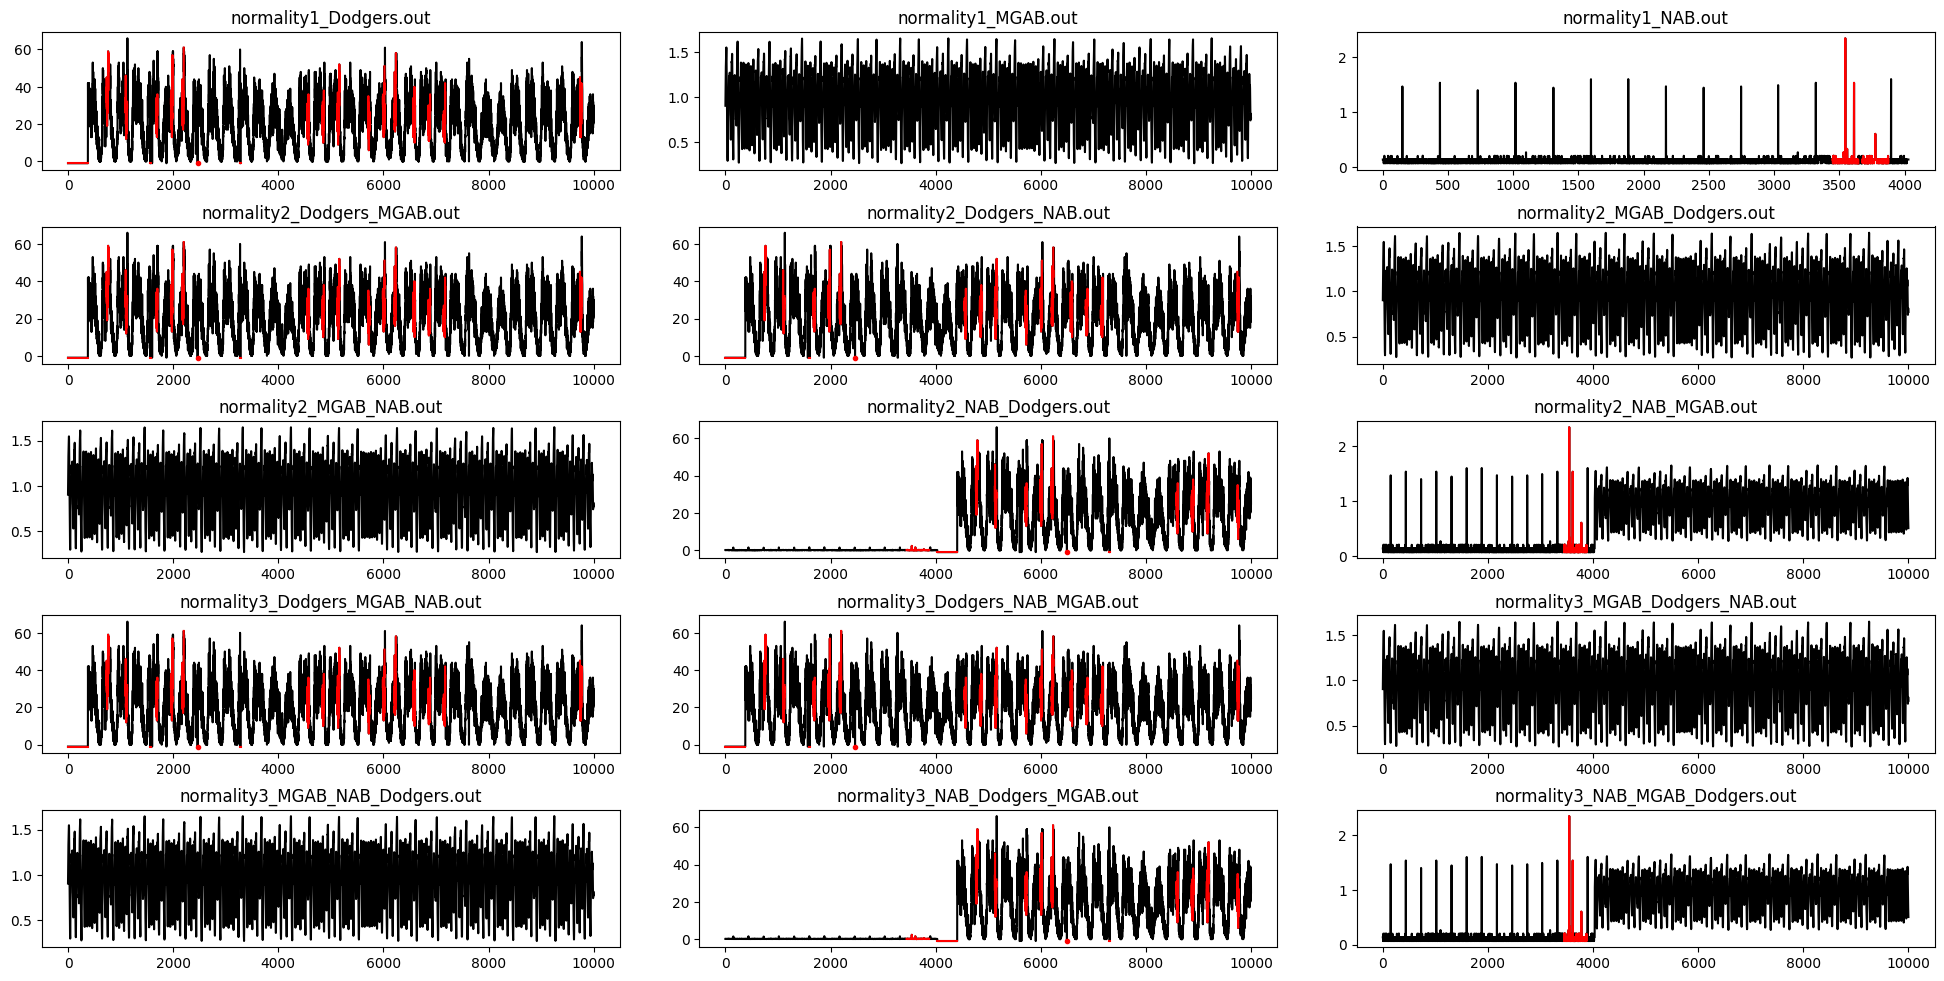

In [22]:
import matplotlib.pyplot as plt
from utils.metrics import metricor

directory = 'generated_data/'

# Create a 3x3 subplot figure
fig, axes = plt.subplots(5, 3, figsize=(20, 10))
fig.tight_layout(pad=2.0)

i = 0
j = 0

grader = metricor()

for filepath in sorted(Path('generated_data').iterdir()):
  if filepath.is_file():
    name = filepath.name
    # Split the string at the first underscore
    parts = name.split("_", 1)

    # Assign the first part (normality2) to one variable and the rest (NAB_MGAB.out) to another
    normality = parts[0][-1]
    dataset = parts[1]

    df = pd.read_csv(filepath, header=None).dropna().to_numpy()

    max_length = 10000

    data = df[:max_length, 0].astype(float)
    label = df[:max_length, 1].astype(int)

    range_anomaly = grader.range_convers_new(label)
  
    axes[i, j].plot(data[:max_length],'k')
    axes[i, j].title.set_text(name)

    for r in range_anomaly:
        if r[0]==r[1]:
            axes[i, j].plot(r[0],data[r[0]],'r.')
        else:
            axes[i, j].plot(range(r[0],r[1]+1),data[range(r[0],r[1]+1)],'r')

    j = (j + 1) % 3
    if j == 0: i += 1
            
            # axes[i, j].xlim(plotRange)

# IForest

## Variant 1
First we are going to run and see the results for the variant 1 of the iForest. Meaning that we just apply iForest in batches.
We are going to try four different values of batch size 1000, 1500, 2000, 2500, 3000.

In [3]:
import time
import os
import iforest_naive
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

directory = 'generated_data/'

result_df = pd.DataFrame(columns=['file_name', 'batch_size', 'AUC', 'time'])

for batch_size in [1000, 1500, 2000, 2500, 3000]:  # batch_size
    for filepath in sorted(Path(directory).iterdir()):
        if filepath.is_file():
            model = iforest_naive.IsolationForestNaiveStream()
            name = filepath.name
            df = pd.read_csv(filepath, header=None).dropna().to_numpy()

            max_length = len(df)

            data = df[:max_length, 0].astype(float)
            label = df[:max_length, 1].astype(int)

            # fit the model
            start_time = time.time()
            model.fit(data, init_length=1000, batch_size=batch_size)  # fit to 1000 first data first
            total_time = time.time() - start_time

            score = model.decision_scores_
            score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
            auc = metrics.roc_auc_score(label, score)

            new_row = {
                       'file_name': name,
                       'batch_size': batch_size,
                       'AUC': auc,
                       'time': total_time}

            result_df.loc[len(result_df)] = new_row

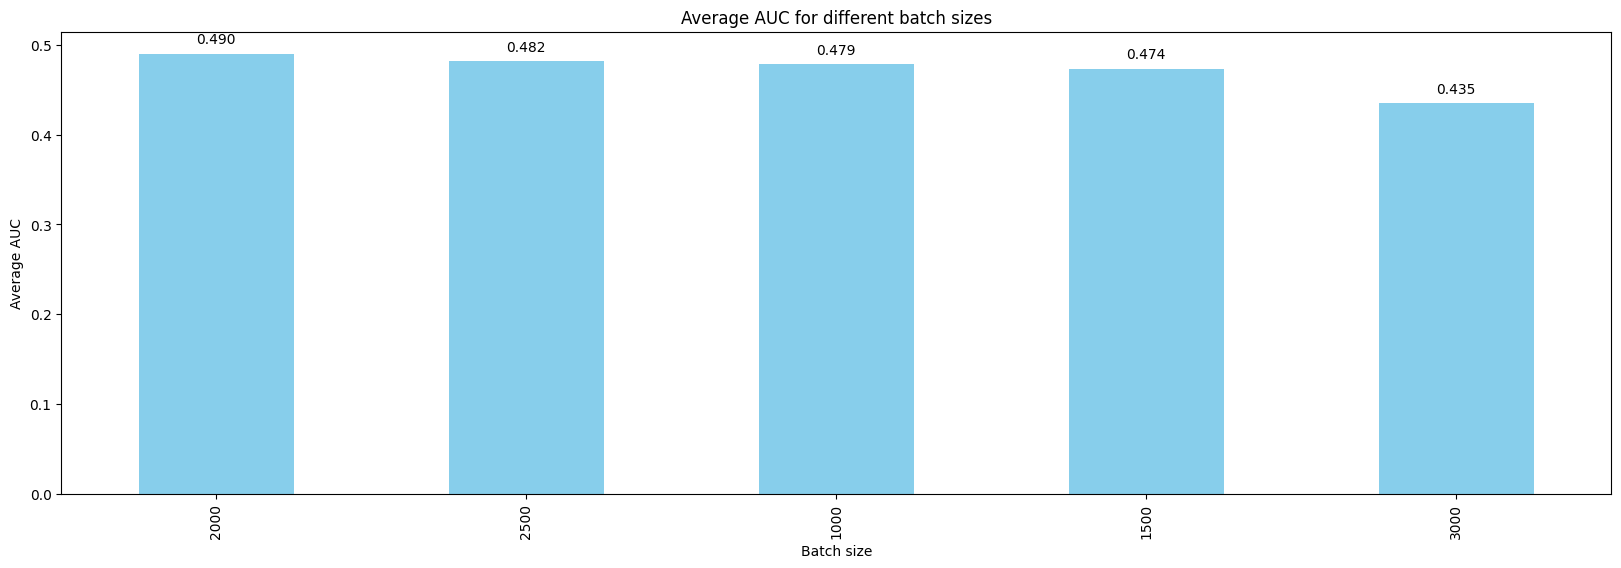

In [24]:
import matplotlib.pyplot as plt
# group by the batch_size columns and calculate the mean of AUC and time
grouped_df = result_df.groupby(['batch_size']).agg({'AUC': 'mean', 'time': 'mean'}).reset_index()

# set the index to the new label column
grouped_df.set_index('batch_size', inplace=True)

# sort the data frame by AUC column
sorted_ROC = grouped_df.sort_values(by=['AUC'], ascending=[False])

# set labels for the plot
ax1 = sorted_ROC['AUC'].plot(kind='bar', figsize=(20, 6), color='skyblue', legend=False)
ax1.set_xlabel('Batch size')
ax1.set_ylabel('Average AUC')
ax1.set_title('Average AUC for different batch sizes')

# show for each bar its value
for p in ax1.patches:
  # color = 'red' if p.get_height() == roc_max_value else 'black'
  # weight = 'bold' if p.get_height() == roc_max_value else 'normal'
  ax1.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
plt.show()

# Sort the DataFrame by ROC and time
sorted_time = grouped_df.sort_values(by=['AUC', 'time'], ascending=[False, True])

# Select the top 20 rows
top20_df = sorted_time.head(20)

# Plot the average time
ax2 = sorted_ROC['time'].plot(kind='bar', figsize=(20, 6), color='#ff9c33', legend=False)
ax2.set_xlabel('Batch size')
ax2.set_ylabel('Average Time (sec)')
ax2.set_title('Average Time for different batch sizes')

for p in ax2.patches:
  # color = 'red' if p.get_height() == roc_max_value else 'black'
  # weight = 'bold' if p.get_height() == roc_max_value else 'normal'
  ax2.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
plt.show()


The highest average AUC has the implementation with batch size equal to 2000.

## Variant 2

Below we are going to run our optimal iforest algorithm. We are going to try different values for the available parameters. In order to do that we are going to use the two helper functions ```run_without_init_training``` and ```run_with_init_training``` from the statistics class.
The ```run_with_init_training``` involved training the model on a fixed, predetermined number of data points (1000), before using the sliding window approach. 
The ```run_without_init_training``` just uses the sliding window approach without any initial training.
The results of the execution will be stored in the file results/result.txt

In [ ]:
from utils import statitstics

statitstics.run_without_init_training()
statitstics.run_with_init_training()

Now we are going to plot all the possible combinations of the different values for:
* window_size: the size of the window to process each time
* anomaly_threshold: if the anomaly score of a point is greater than the anomaly_threshold value then the point is considered an anomaly
* drift_threshold: used to decide if the model is going to be retrained, if the current anomaly rate is higher than the drift_threshold then the model gets retrained.
* init_training: true if the model has been trained on an initial number of points or else false

Our goal is to find which one has the highest AUC value.

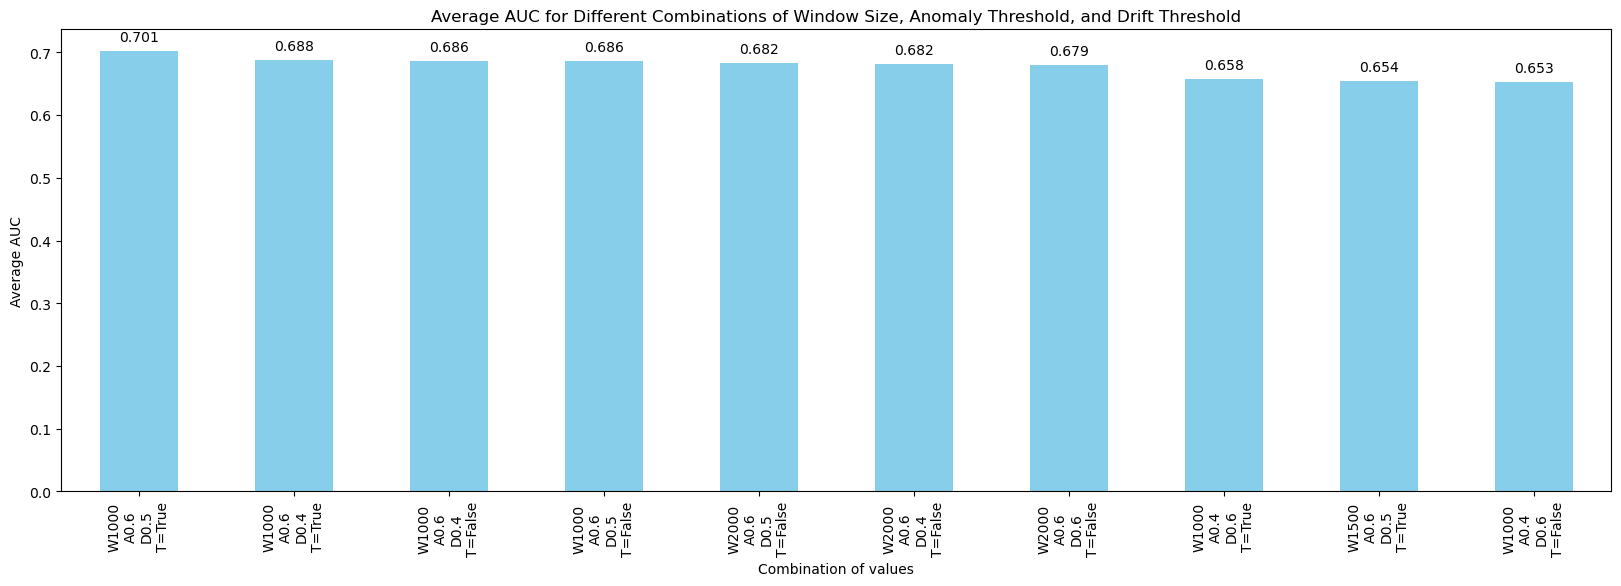

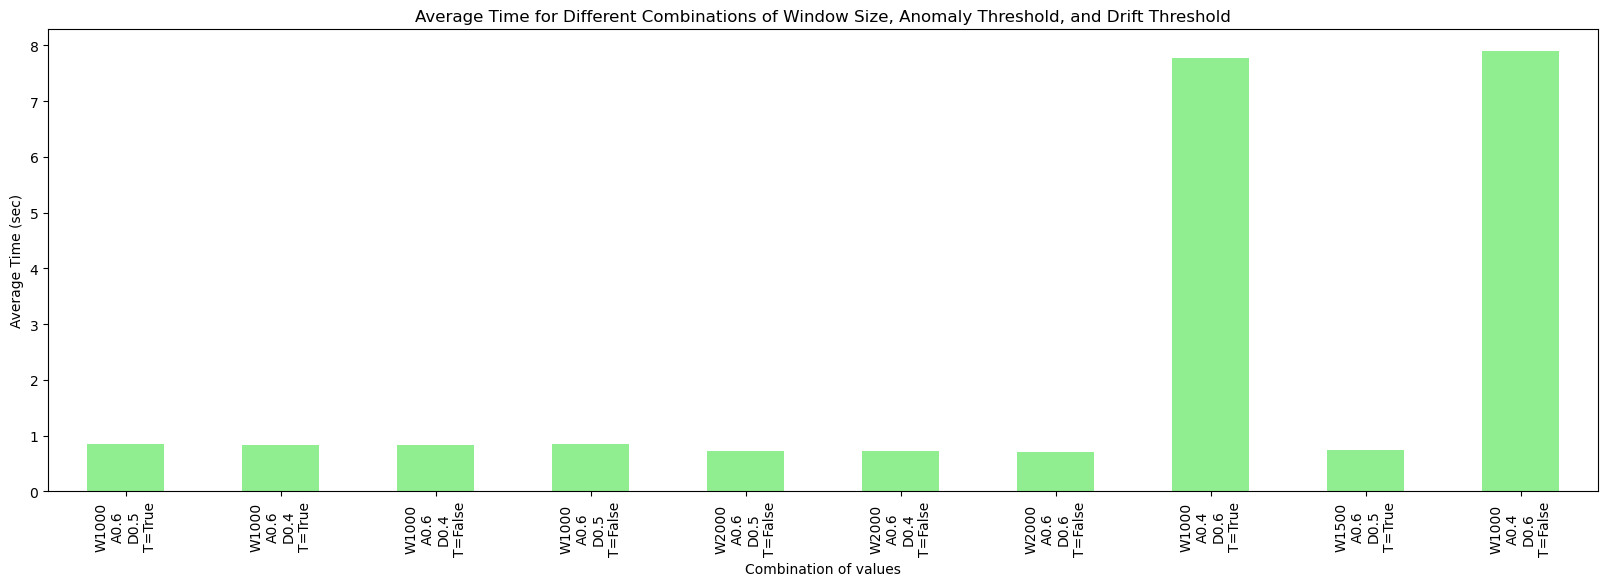

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# load the data from the result.txt file into a pandas data frame
file_path = 'results/result.txt'
df = pd.read_csv(file_path)

# create a new column combining window_size, anomaly_threshold, drift_threshold and training
df['window_anomaly_drift_training'] = df.apply(lambda row: f'W{row.window_size}_A{row.anomaly_threshold}_D{row.drift_threshold}_Τ{row.init_training}', axis=1)

# group by the above columns and calculate the mean of AUC and time
grouped_df = df.groupby(['window_size', 'anomaly_threshold', 'drift_threshold', 'init_training']).agg({'AUC': 'mean', 'time': 'mean'}).reset_index()

# ------- Plot the results ------
# create a new column for the plot's labels containg all the columns we want to test
grouped_df['window_anomaly_drift_training'] = grouped_df.apply(lambda row: f'W{row.window_size}\nA{row.anomaly_threshold}\nD{row.drift_threshold}\nT={row.init_training}', axis=1)

# set index to the created column
grouped_df.set_index('window_anomaly_drift_training', inplace=True)

# sort data frame by AUC in an descending order
sorted_AUC = grouped_df.sort_values(by=['AUC'], ascending=[False])

# get the top 20 rows
top20_df = sorted_AUC.head(10)

# plot the average AUC
ax1 = top20_df['AUC'].plot(kind='bar', figsize=(20, 6), color='skyblue', legend=False)
ax1.set_xlabel('Combination of values')
ax1.set_ylabel('Average AUC')
ax1.set_title('Average AUC for Different Combinations of Window Size, Anomaly Threshold, and Drift Threshold')

# set labels for each plot bar
for p in ax1.patches:
  ax1.annotate(f'{p.get_height():.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black')
plt.show()


# sort data frame by AUC in an descending order and time in ascending
sorted_time = grouped_df.sort_values(by=['AUC', 'time'], ascending=[False, True])

# get the top 20 rows
top20_df = sorted_time.head(10)

# plot the average time
ax2 = top20_df['time'].plot(kind='bar', figsize=(20, 6), color='lightgreen', legend=False)
ax2.set_xlabel('Combination of values')
ax2.set_ylabel('Average Time (sec)')
ax2.set_title('Average Time for Different Combinations of Window Size, Anomaly Threshold, and Drift Threshold')
plt.show()

## Optimal vs Naive
Now, we are going to run both our implementations to all the files, with the best parameters.

generated_data\normality1_Dodgers.out


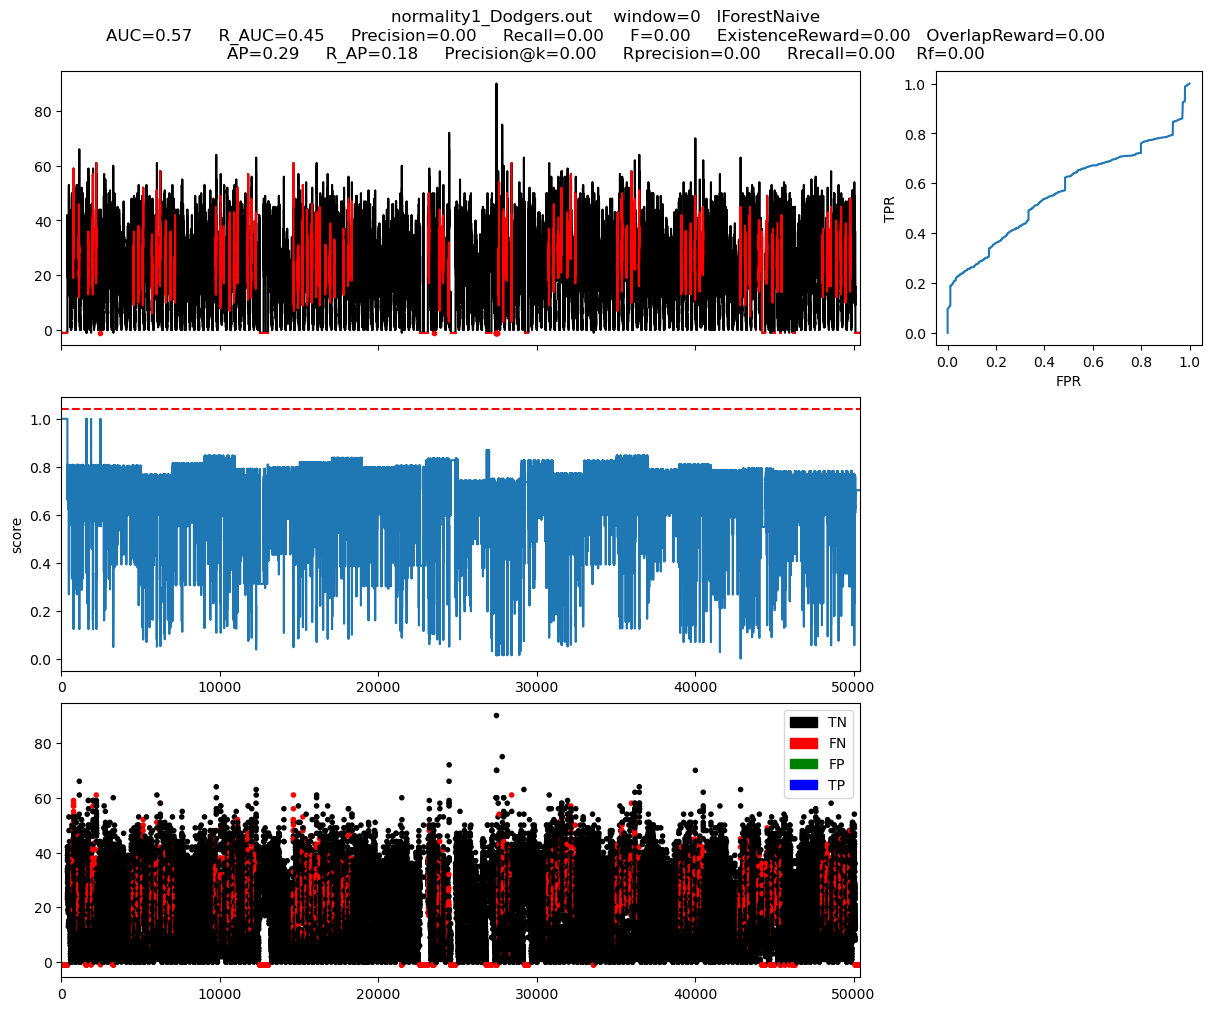

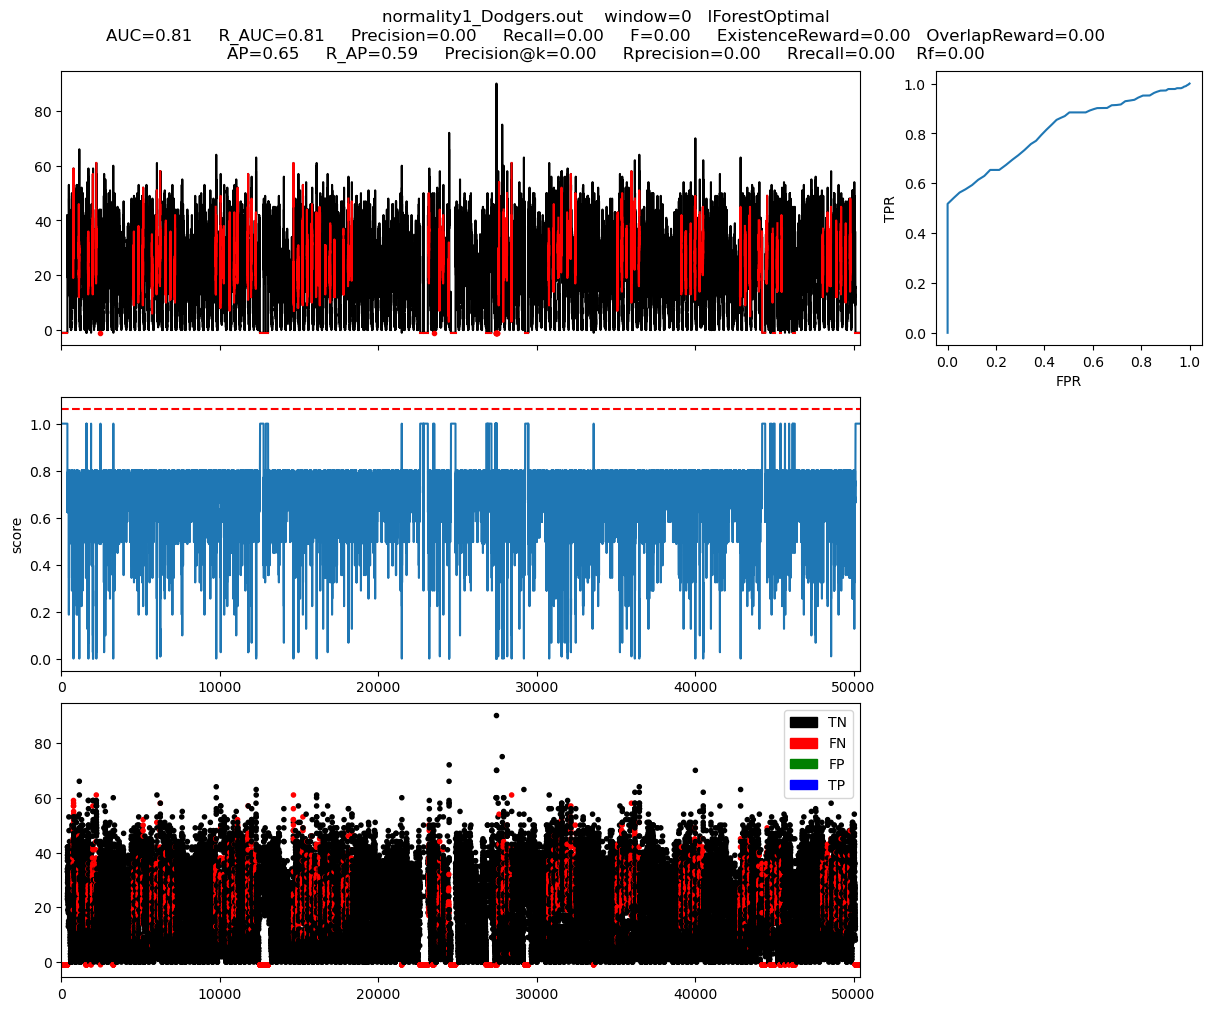



generated_data\normality1_MGAB.out


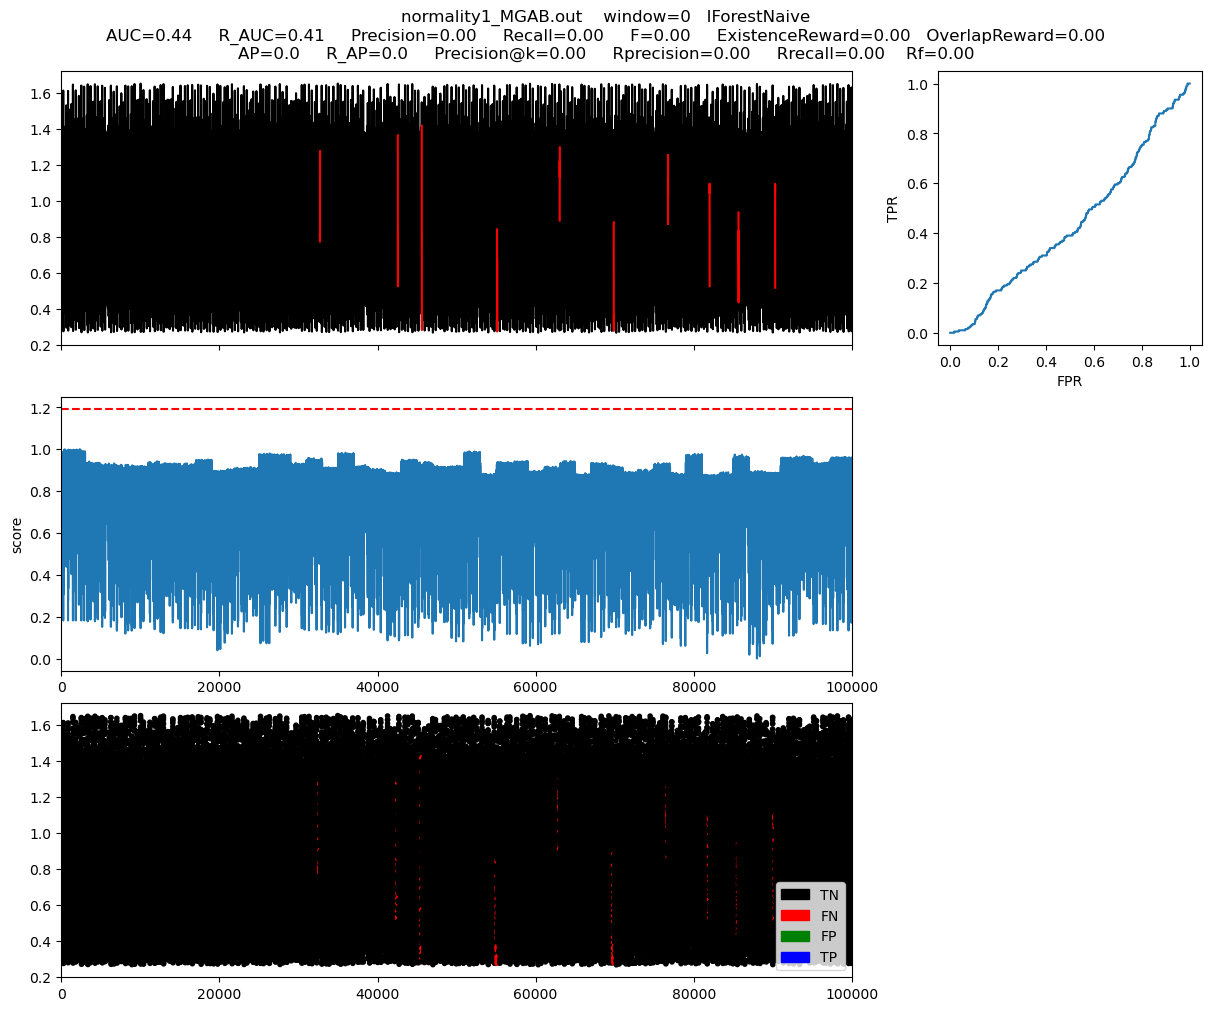

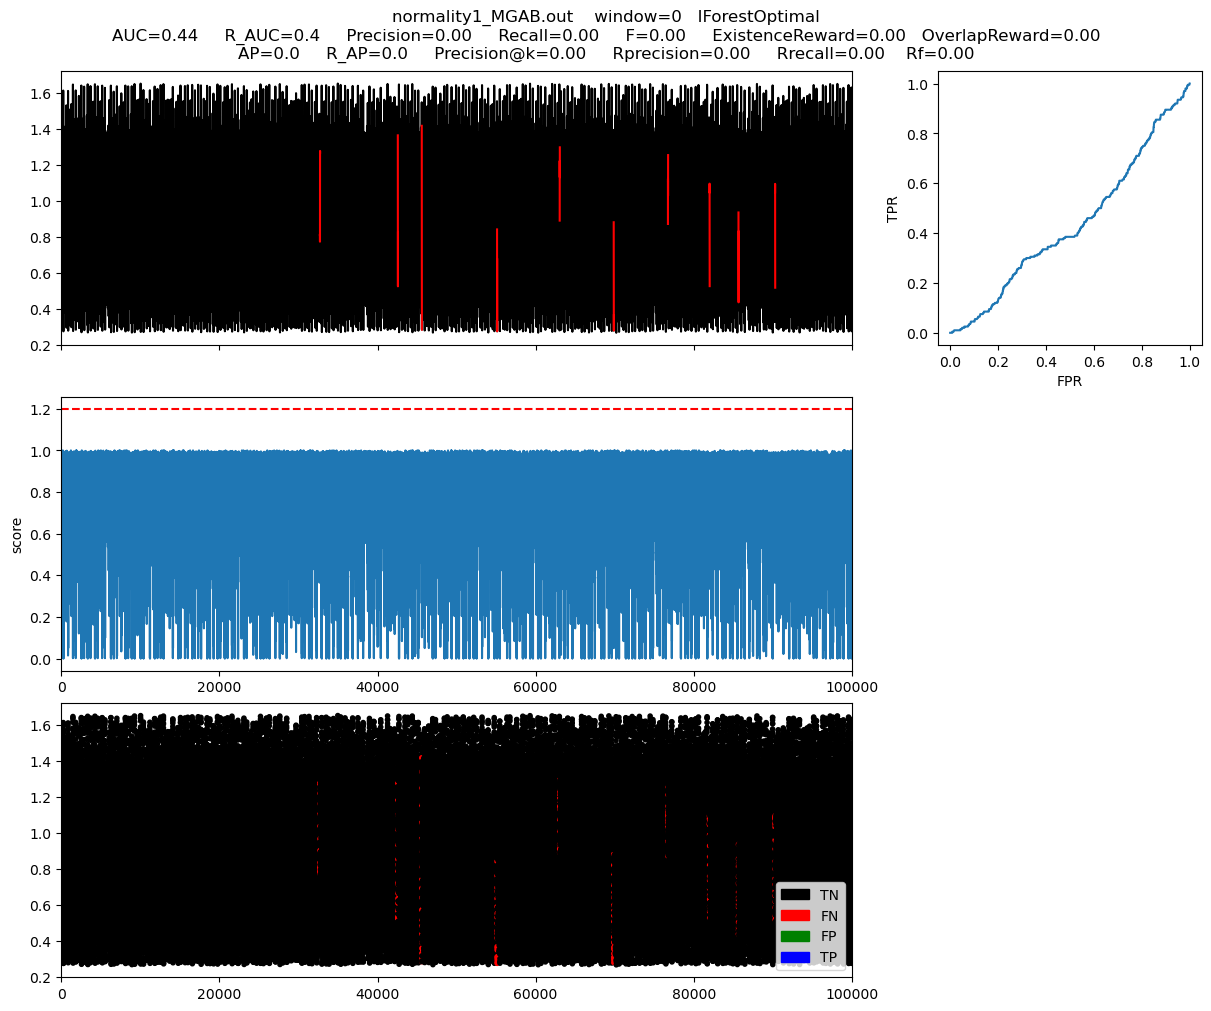



generated_data\normality1_NAB.out


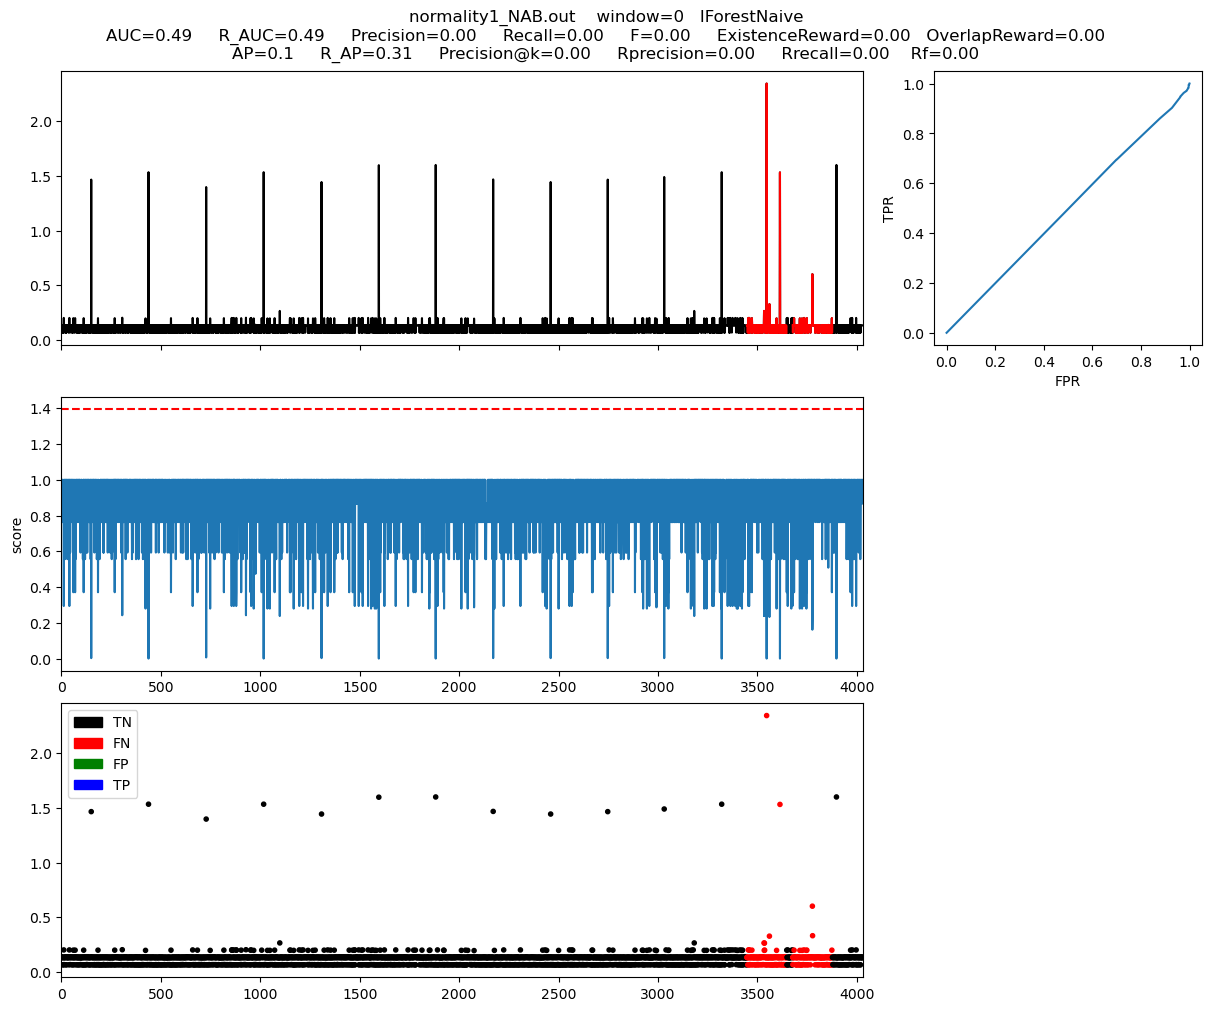



generated_data\normality2_Dodgers_MGAB.out


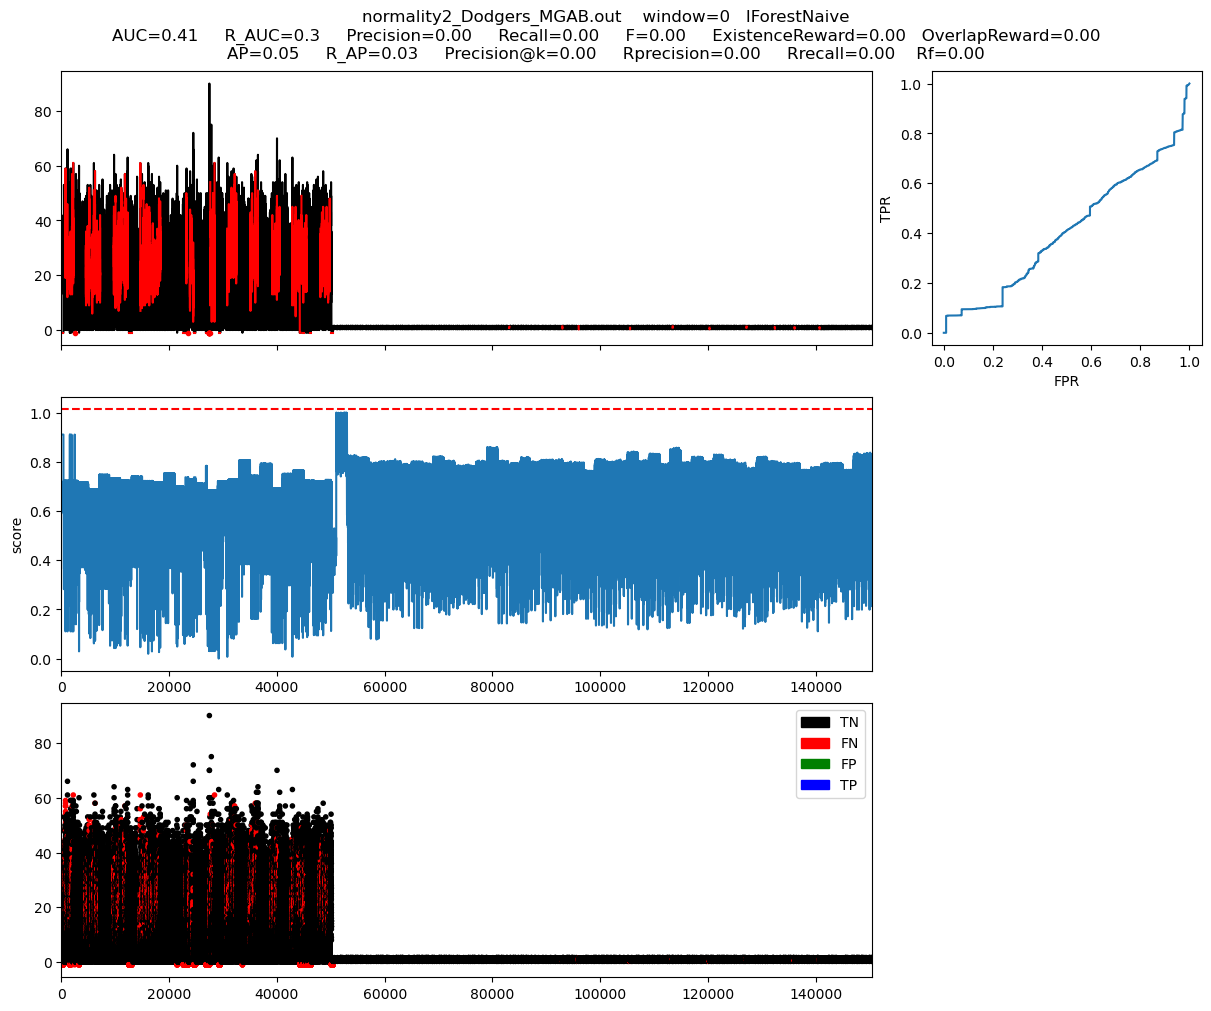

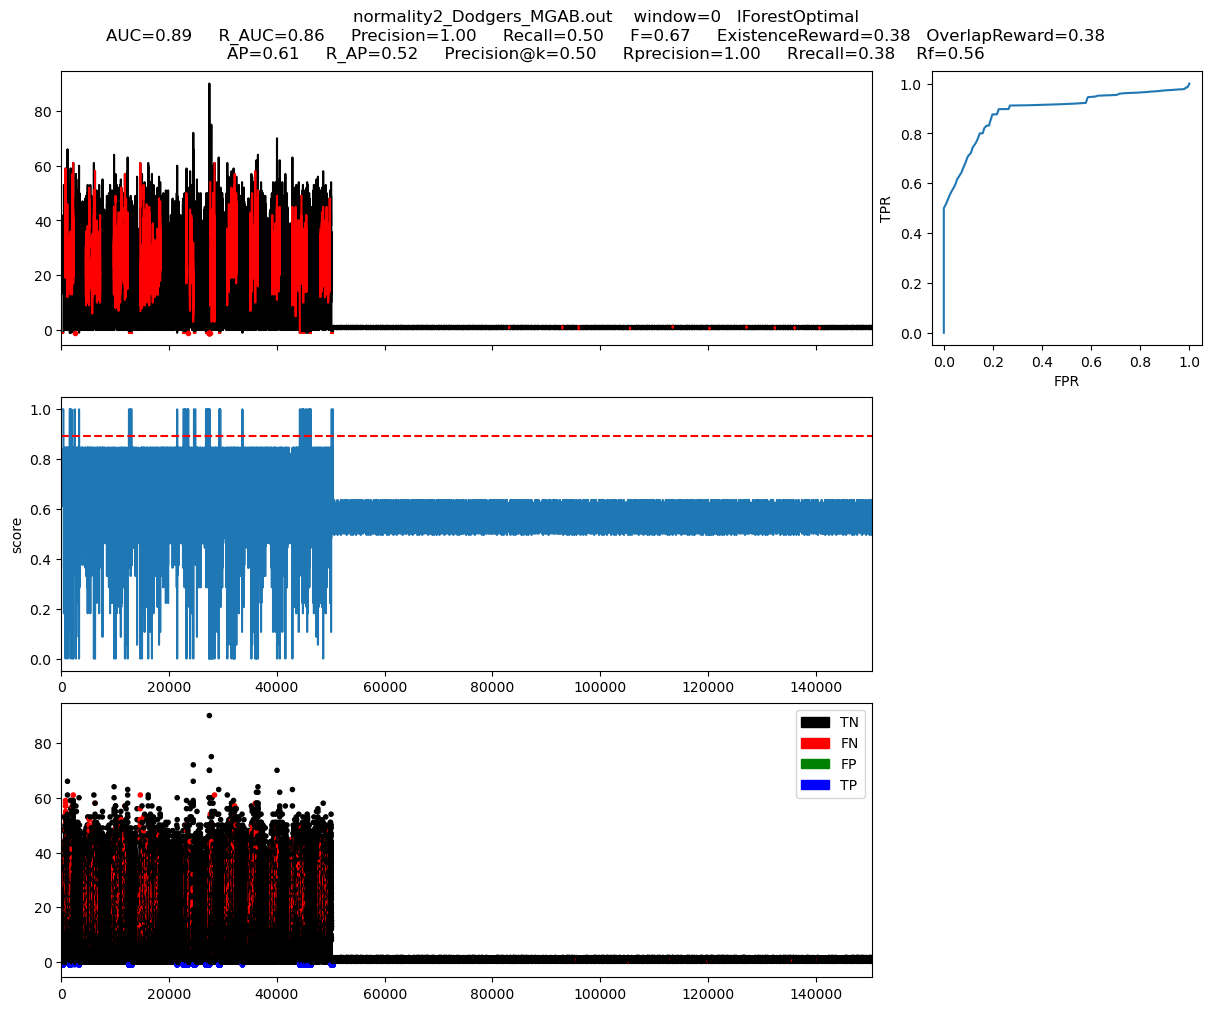



generated_data\normality2_Dodgers_NAB.out


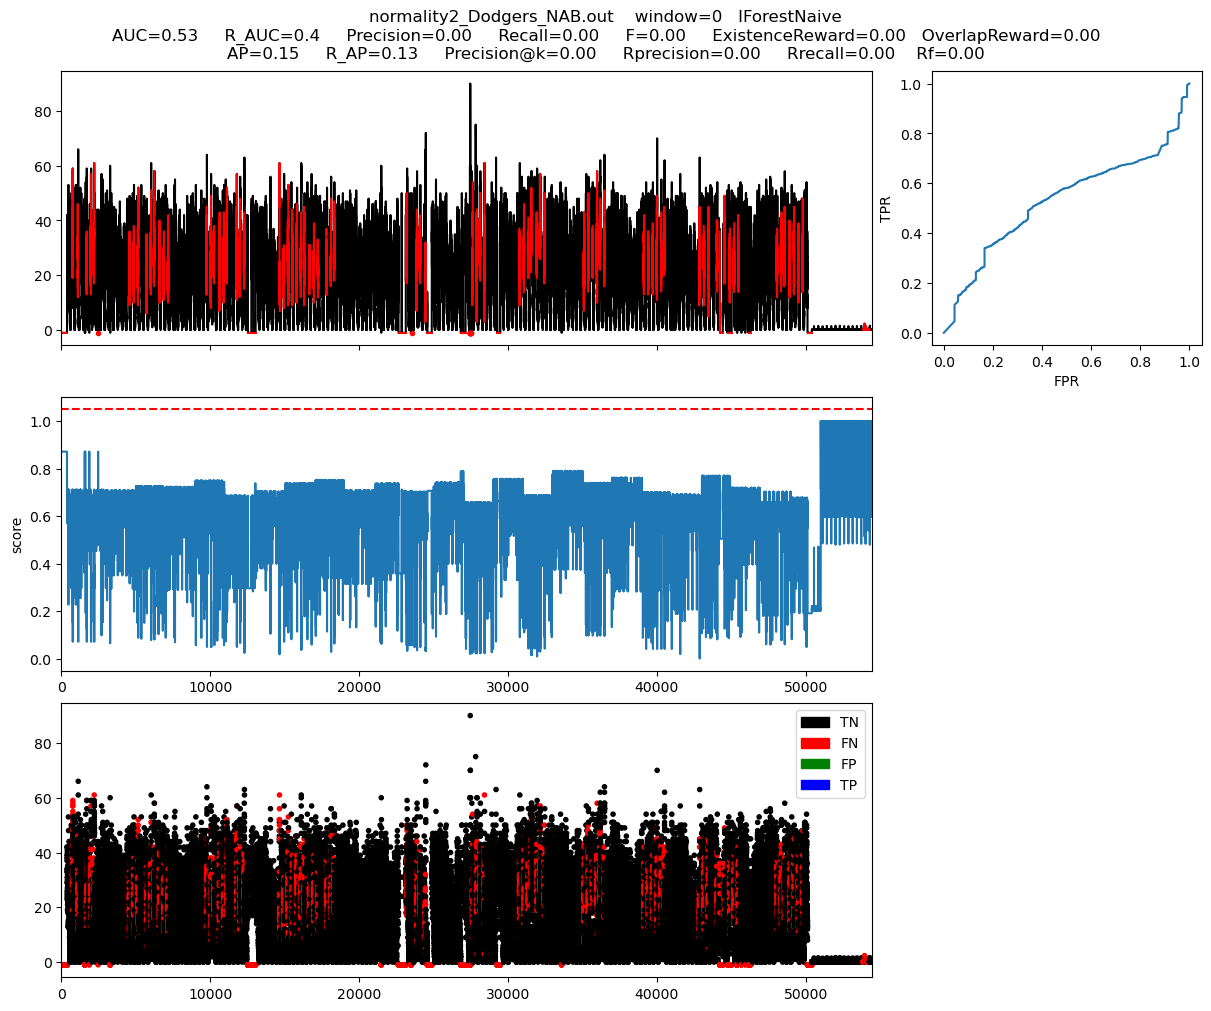



generated_data\normality2_MGAB_Dodgers.out




generated_data\normality2_MGAB_NAB.out


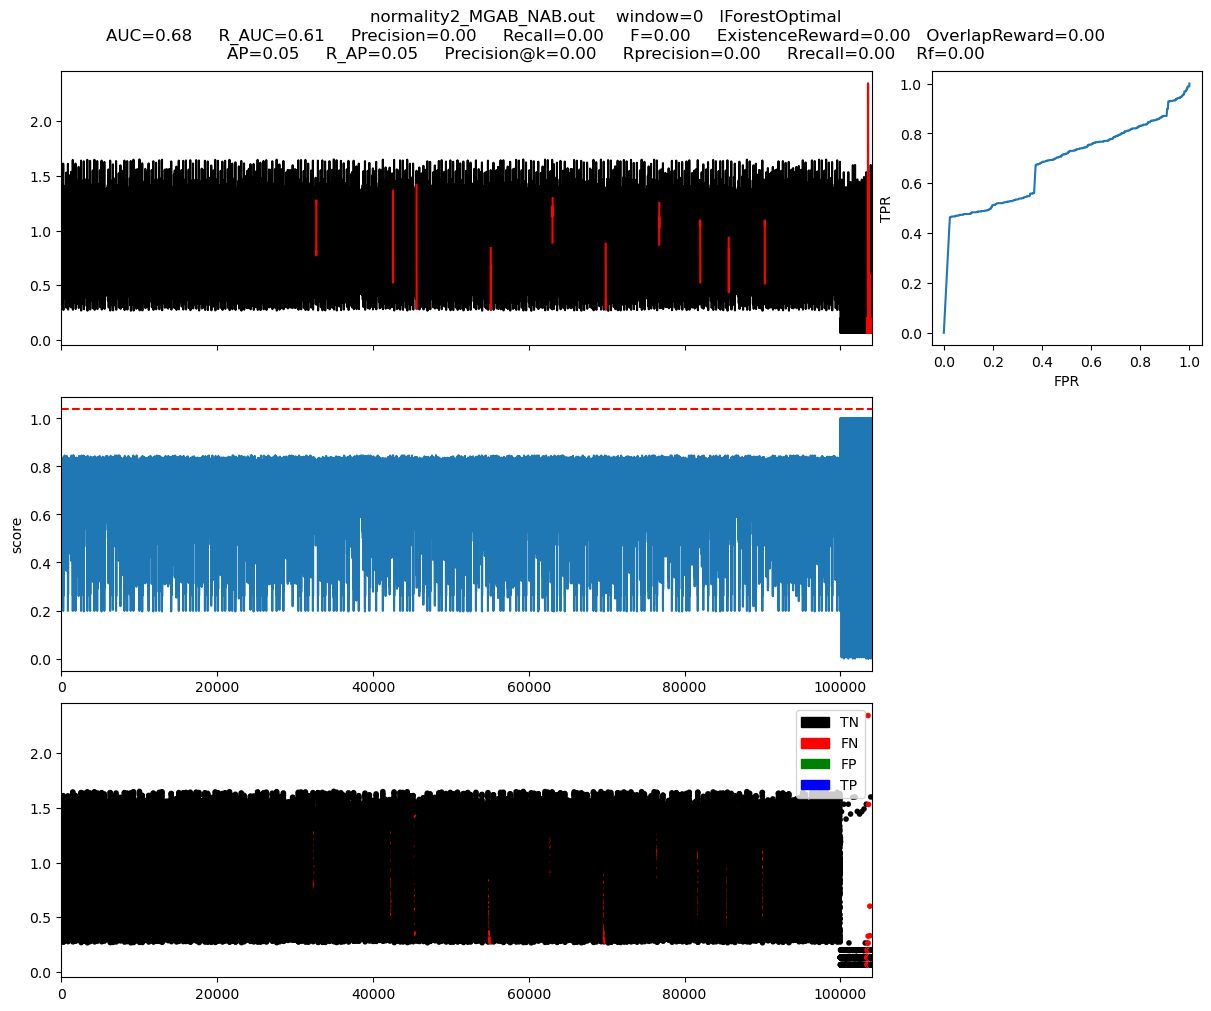



generated_data\normality2_NAB_Dodgers.out


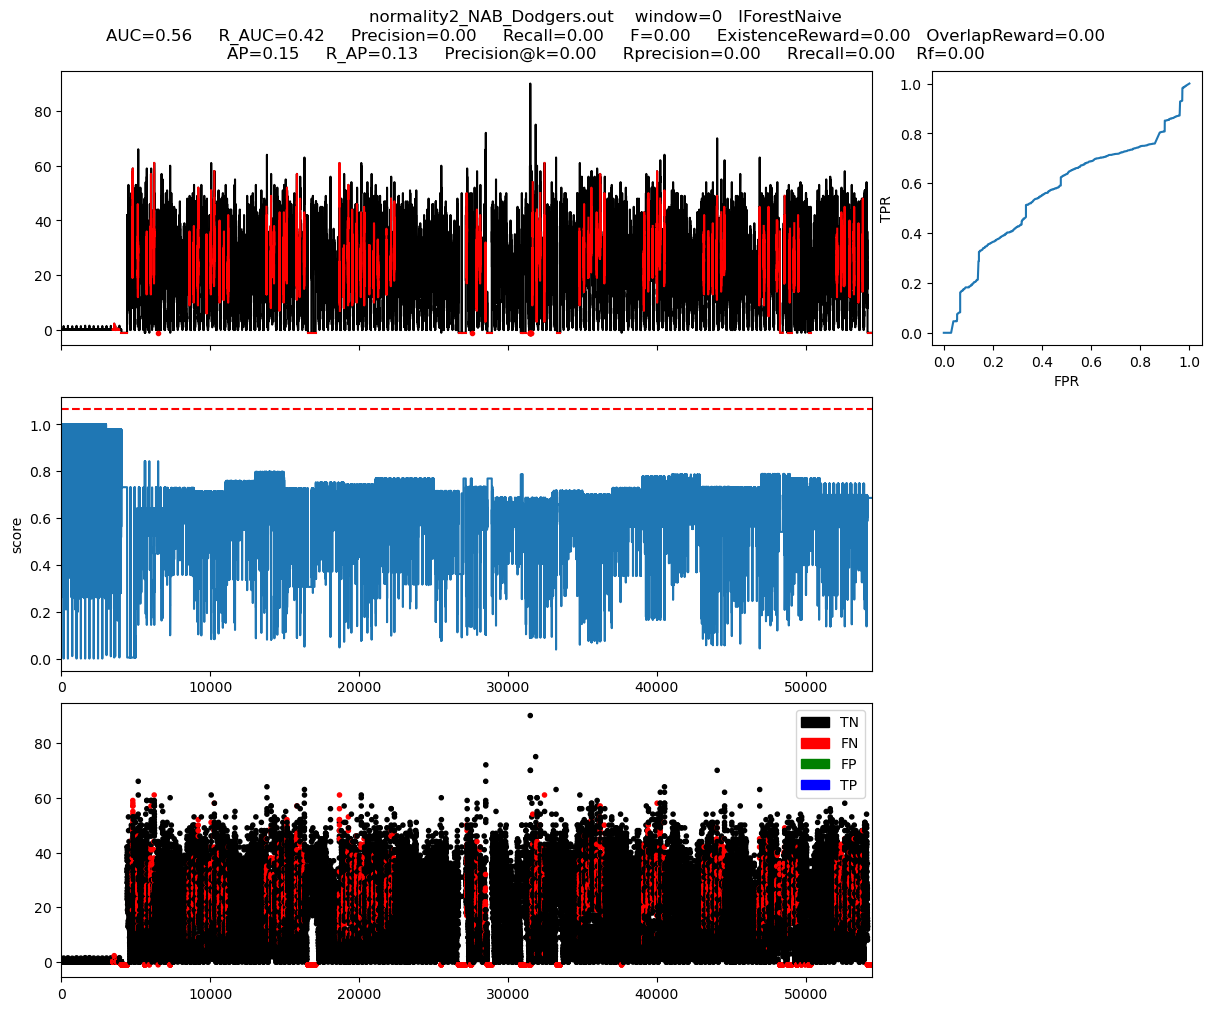

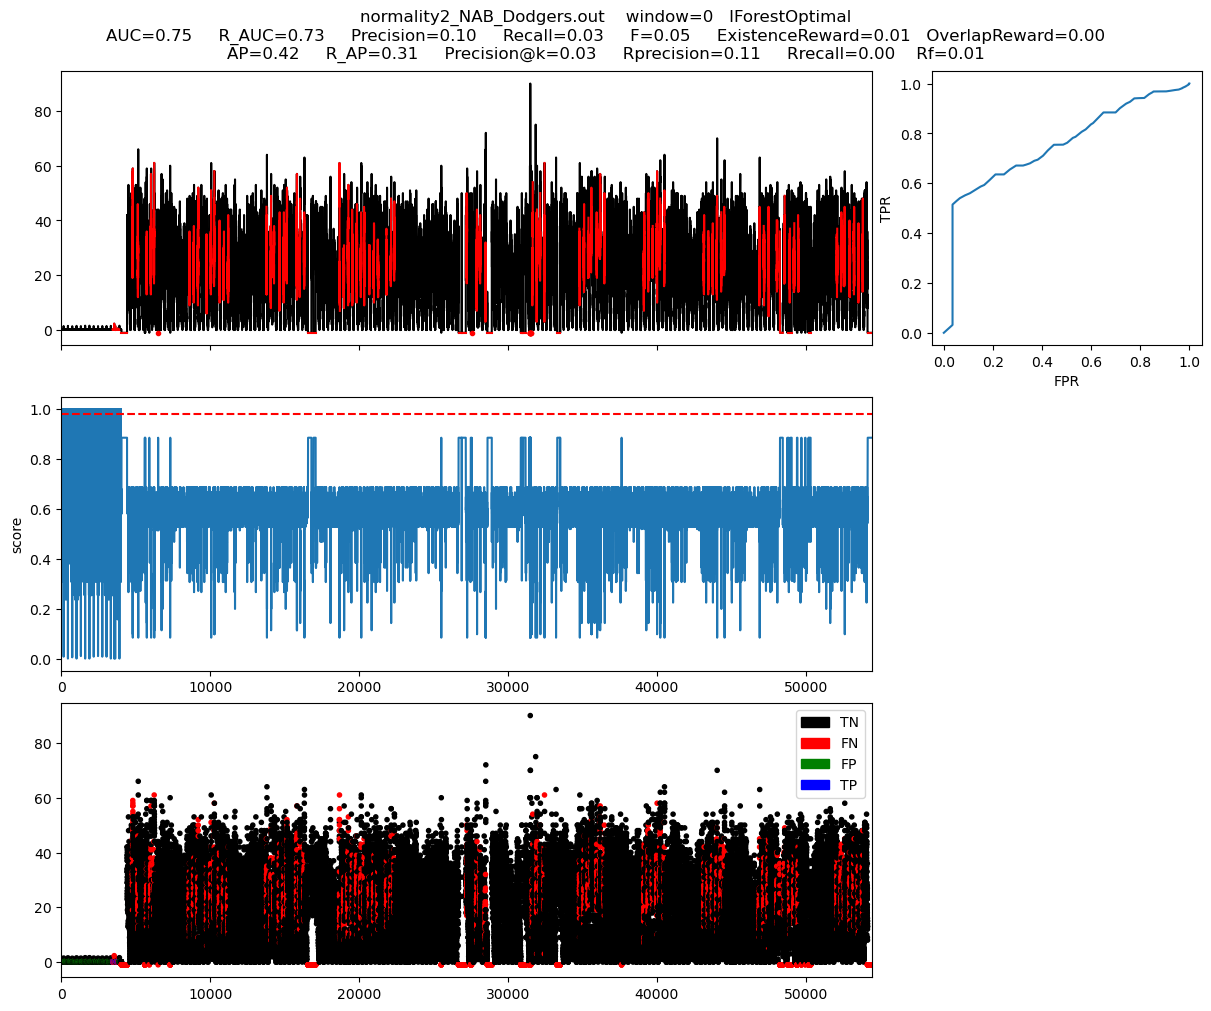



generated_data\normality2_NAB_MGAB.out


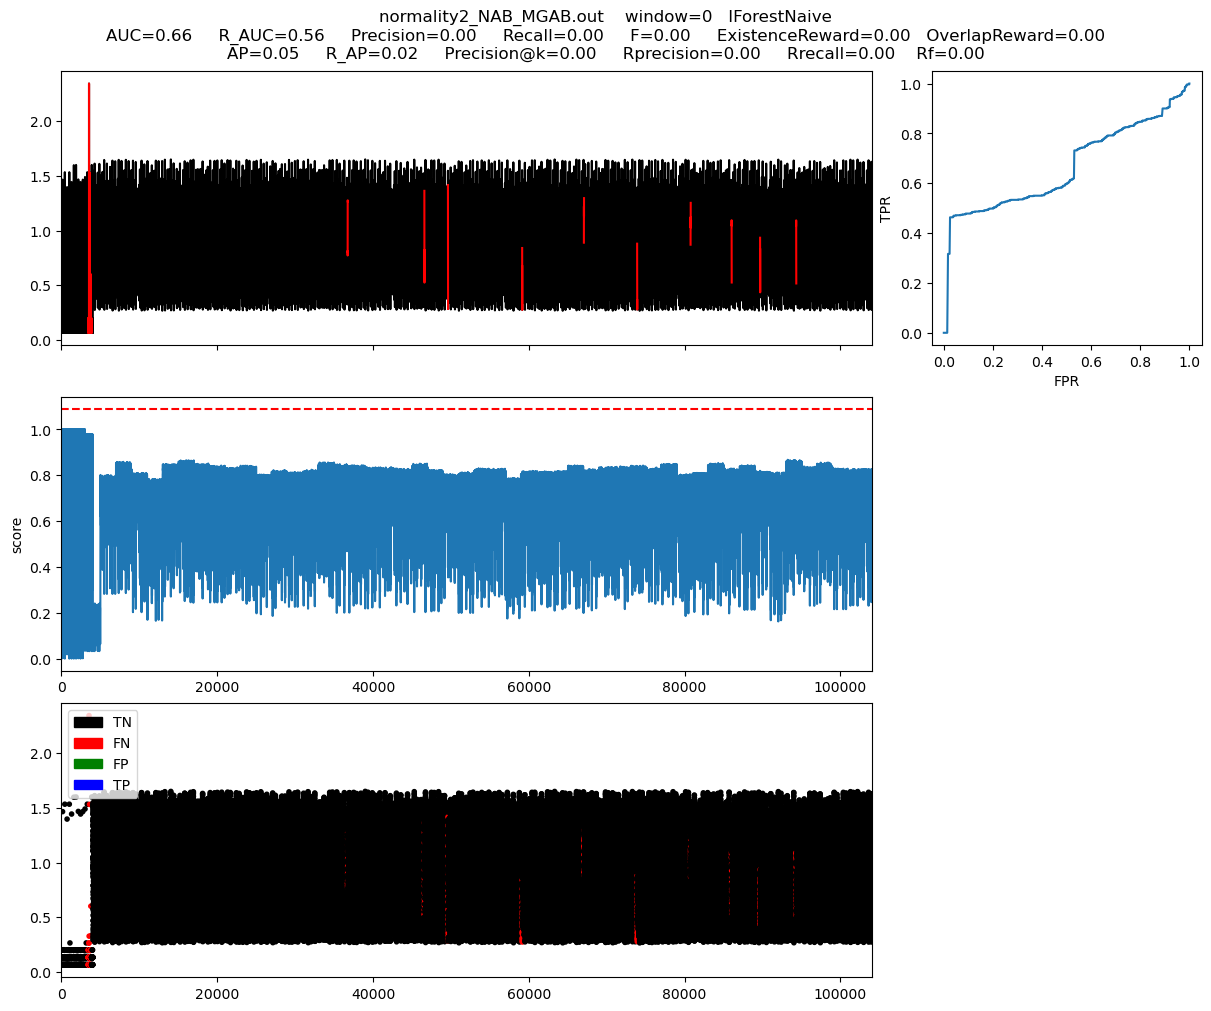



generated_data\normality3_Dodgers_MGAB_NAB.out


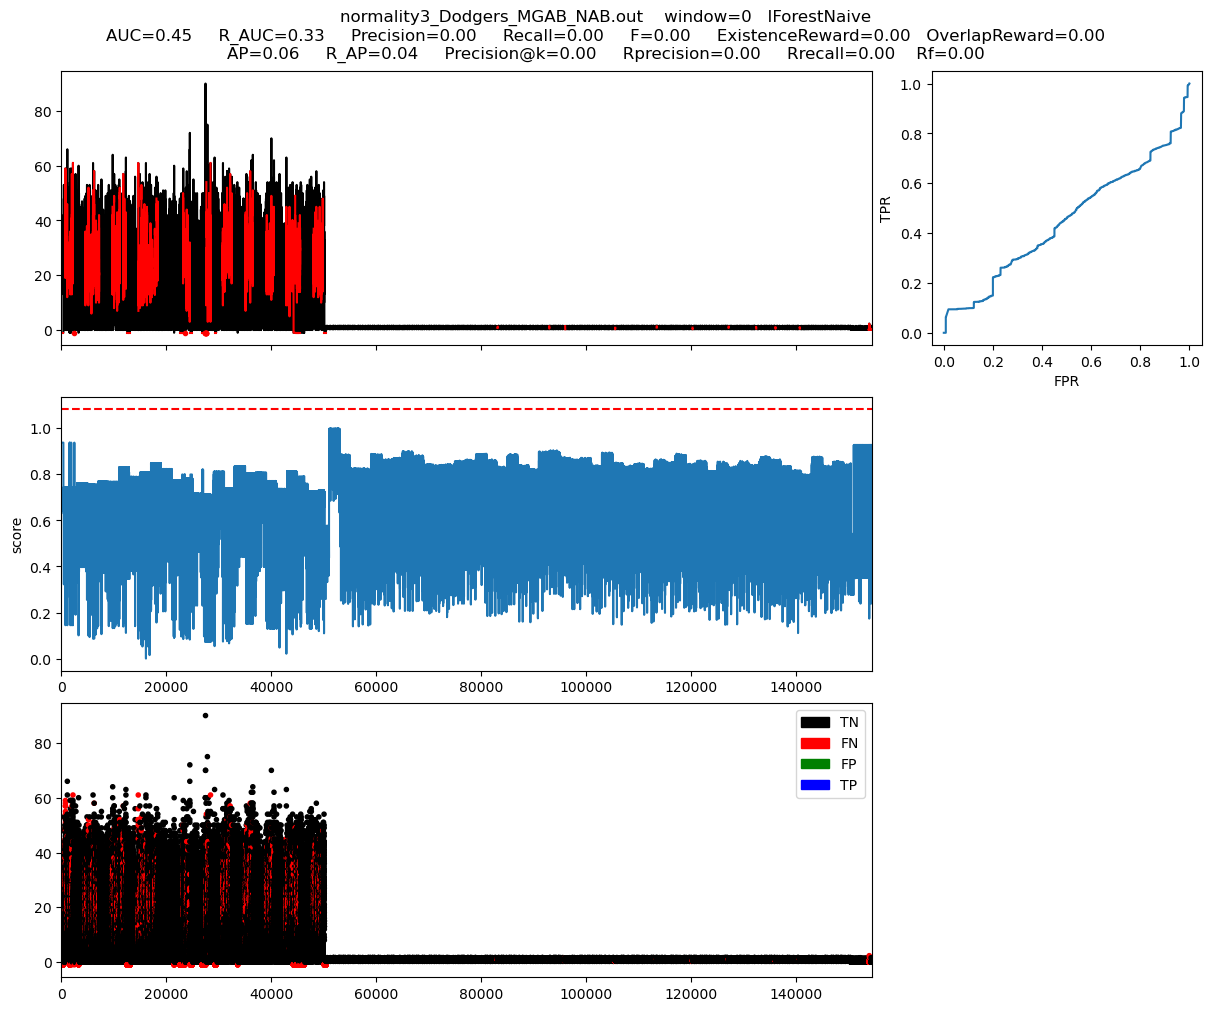

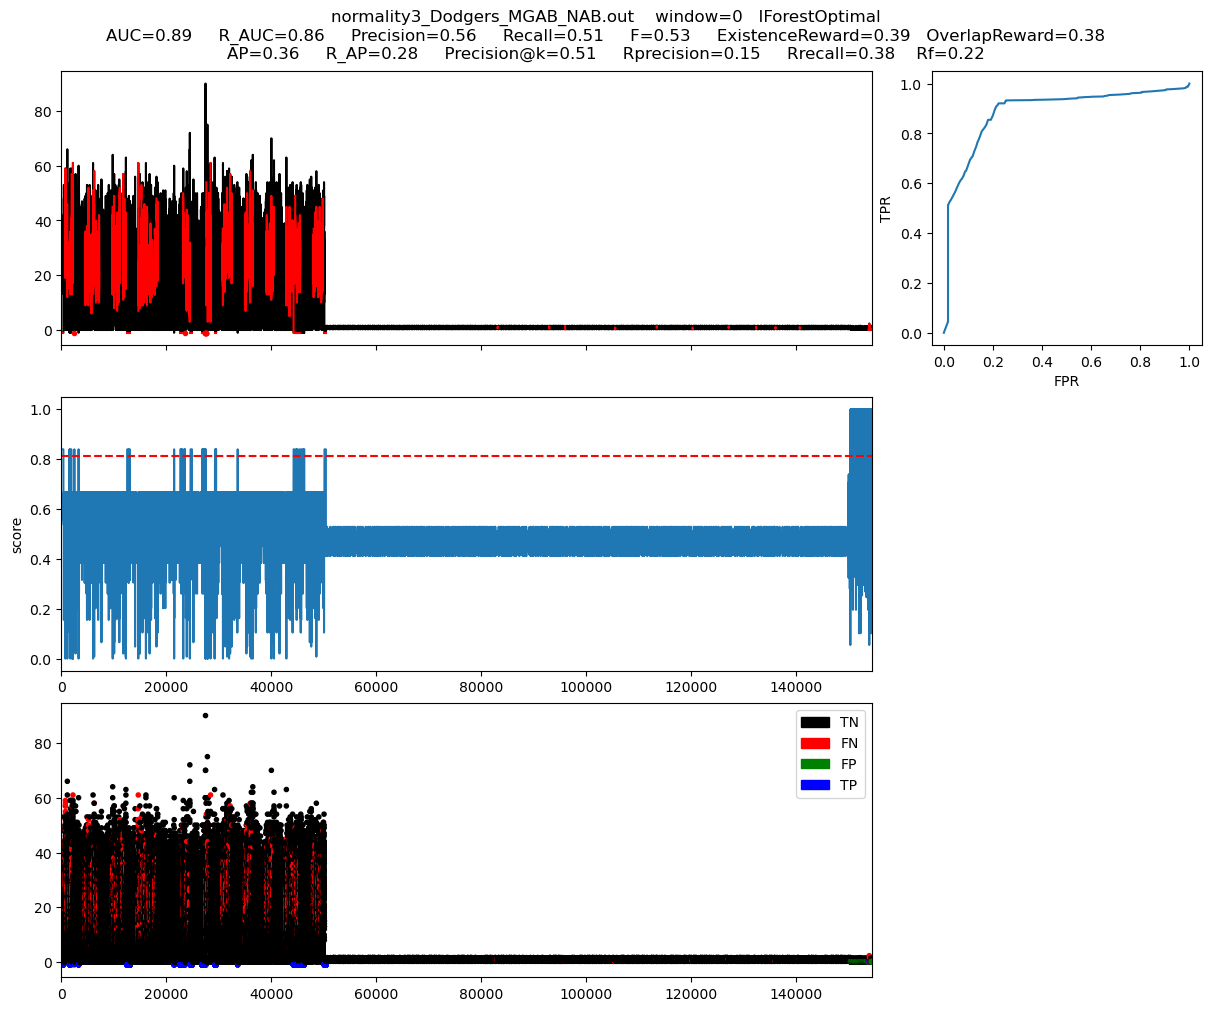



generated_data\normality3_Dodgers_NAB_MGAB.out


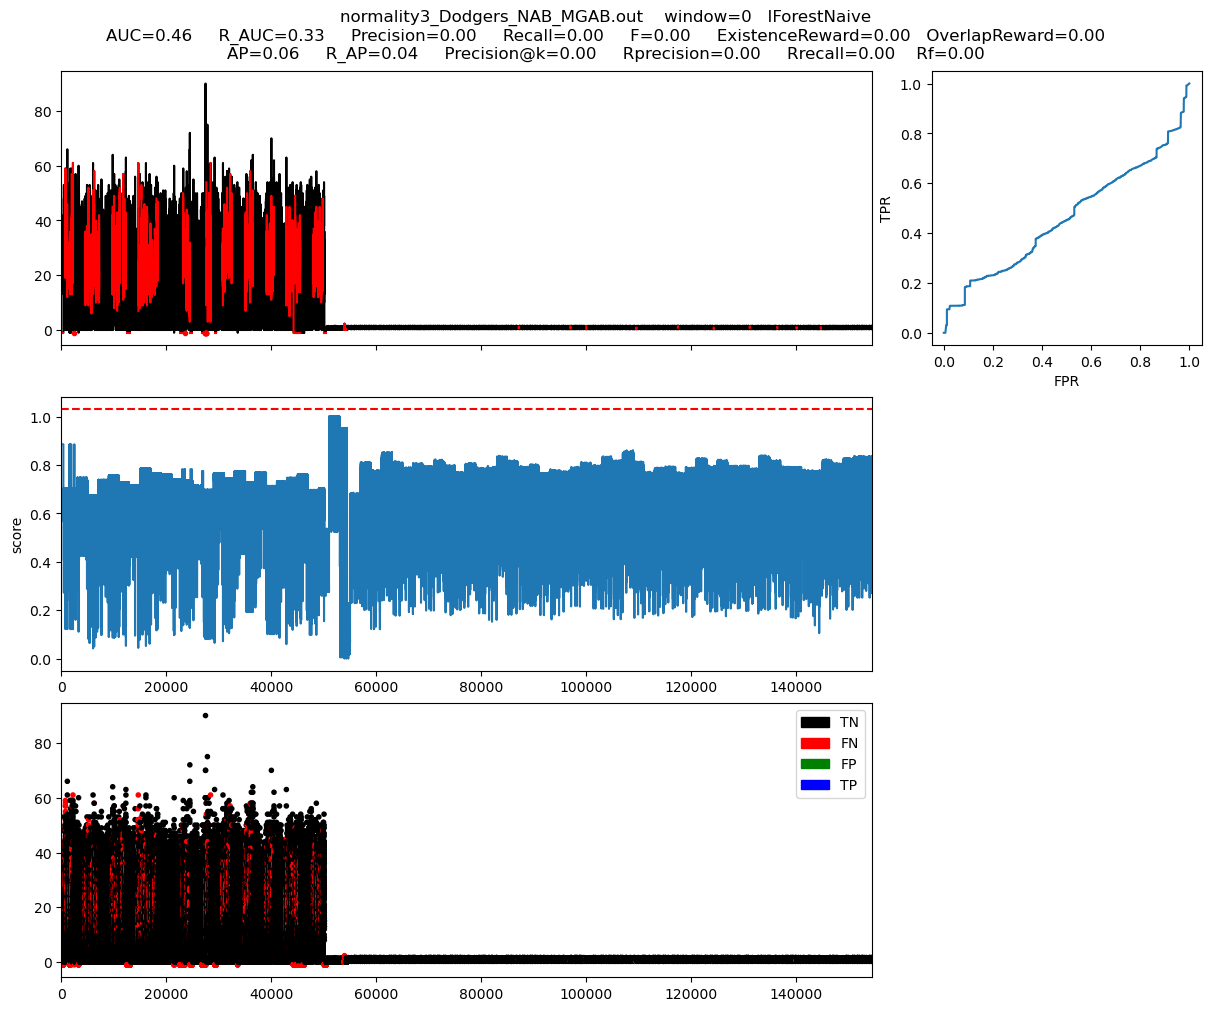

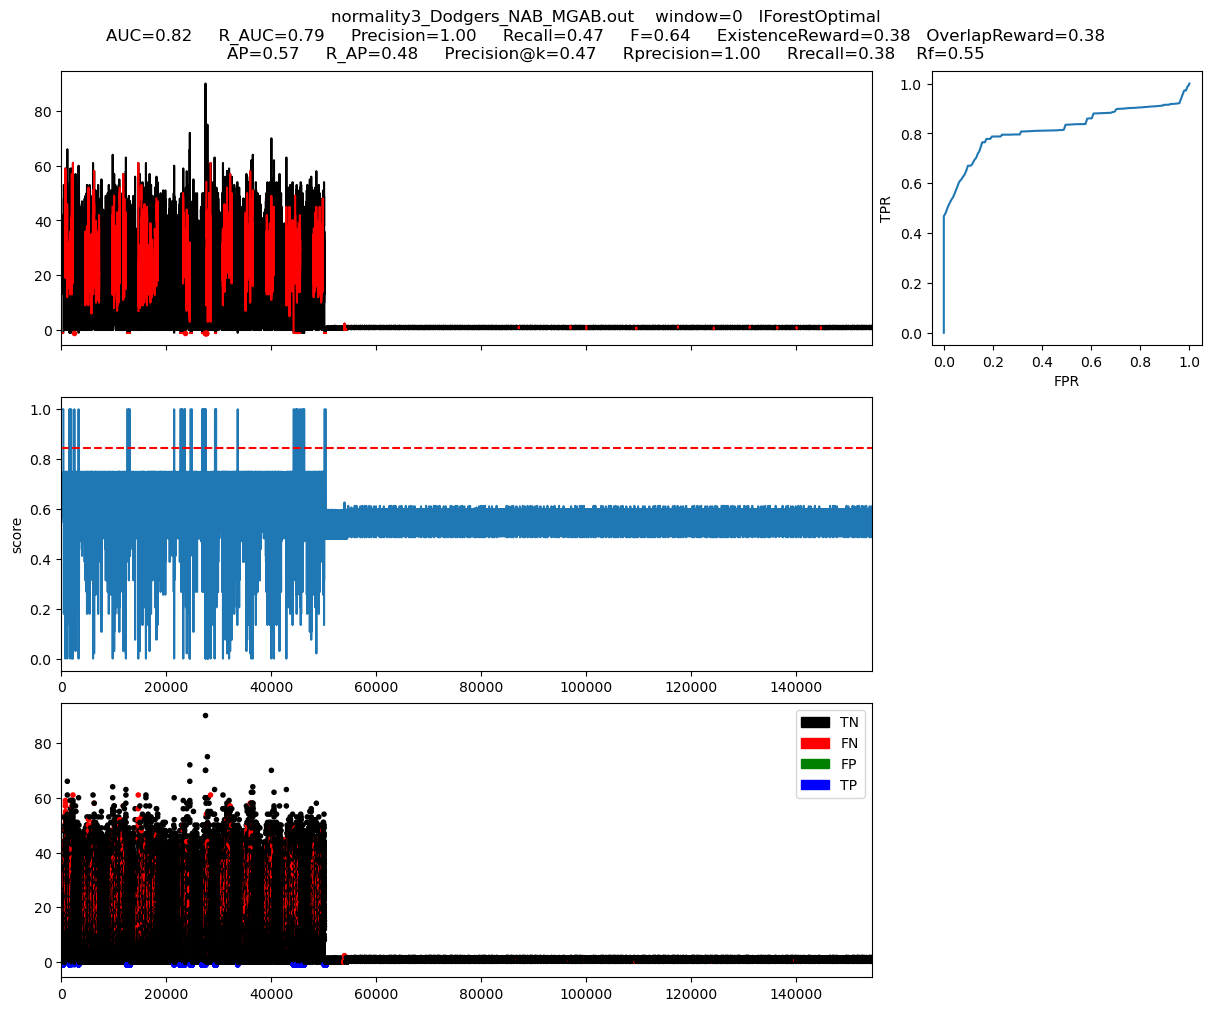



generated_data\normality3_MGAB_Dodgers_NAB.out


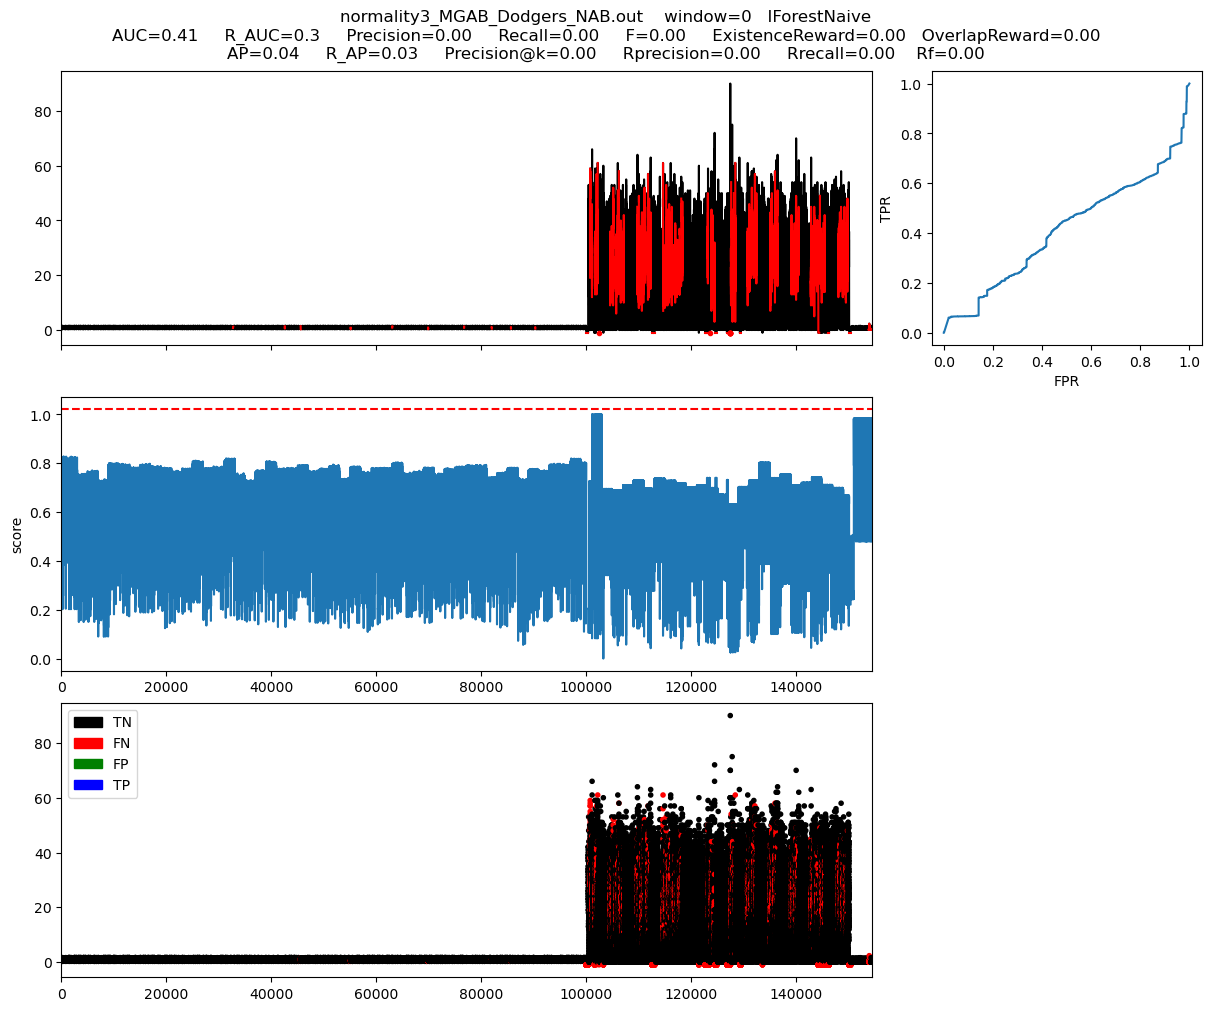

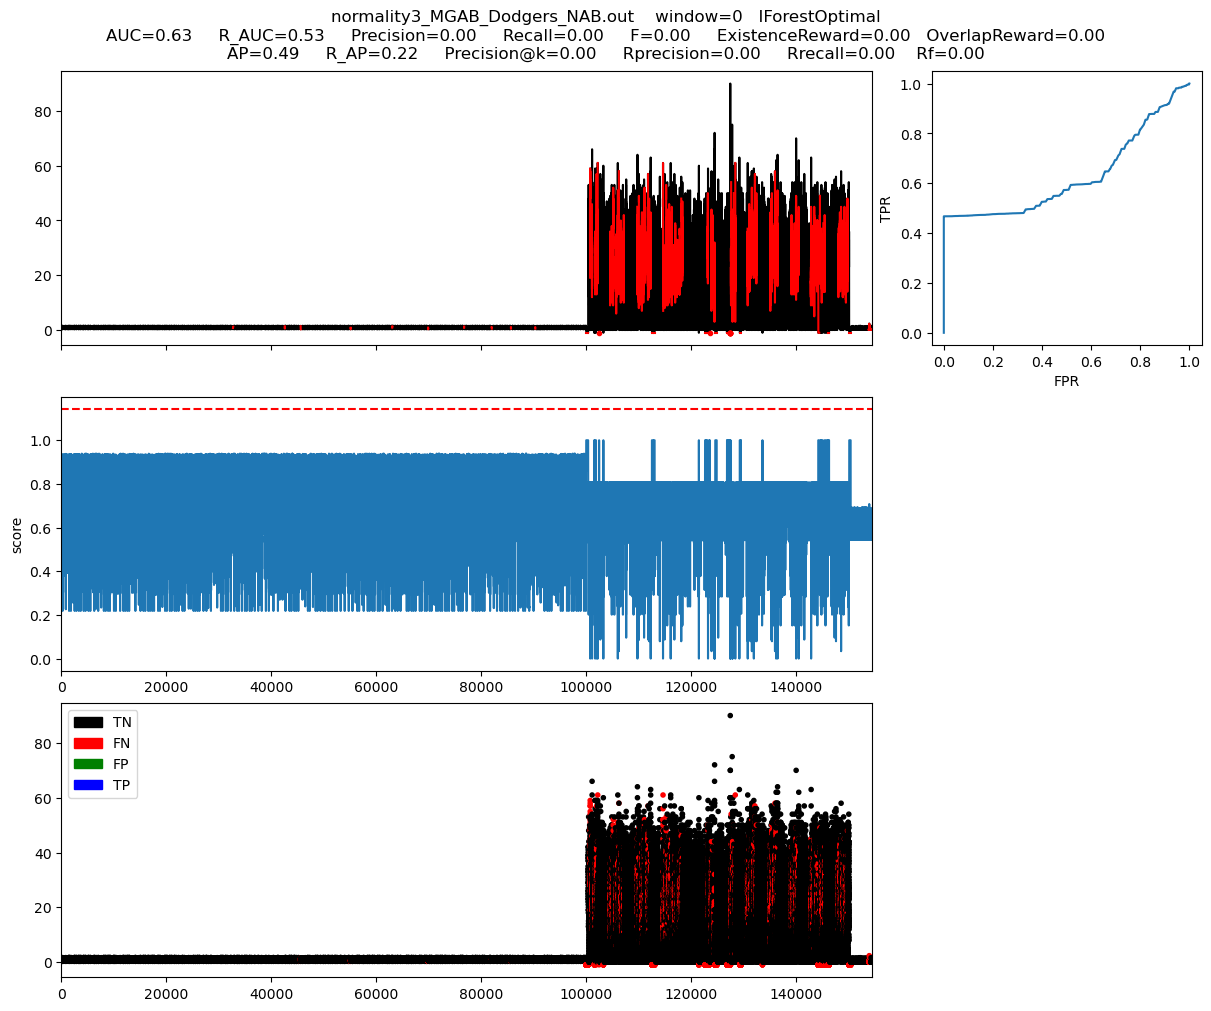



generated_data\normality3_MGAB_NAB_Dodgers.out


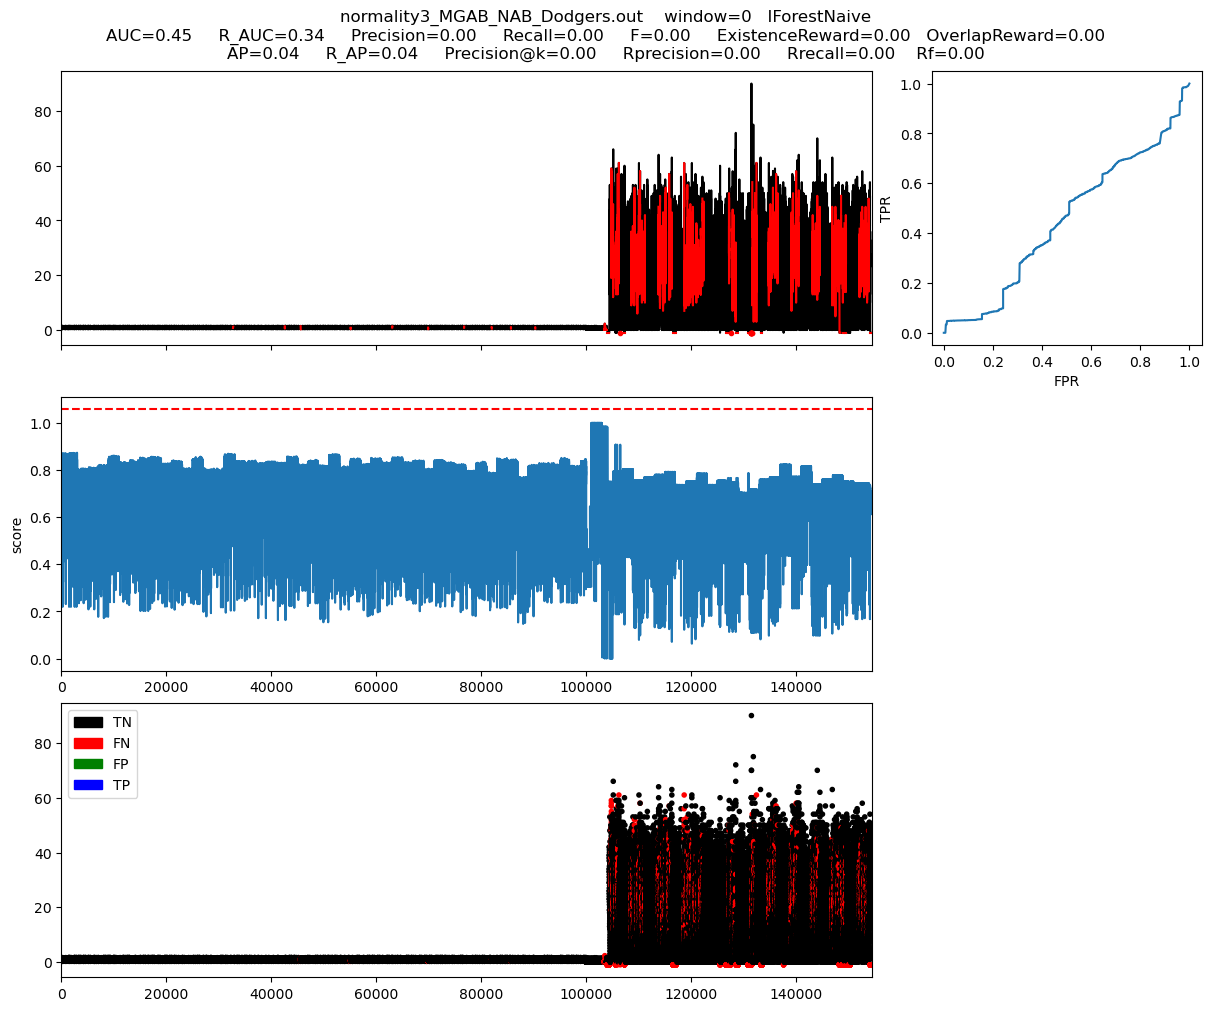

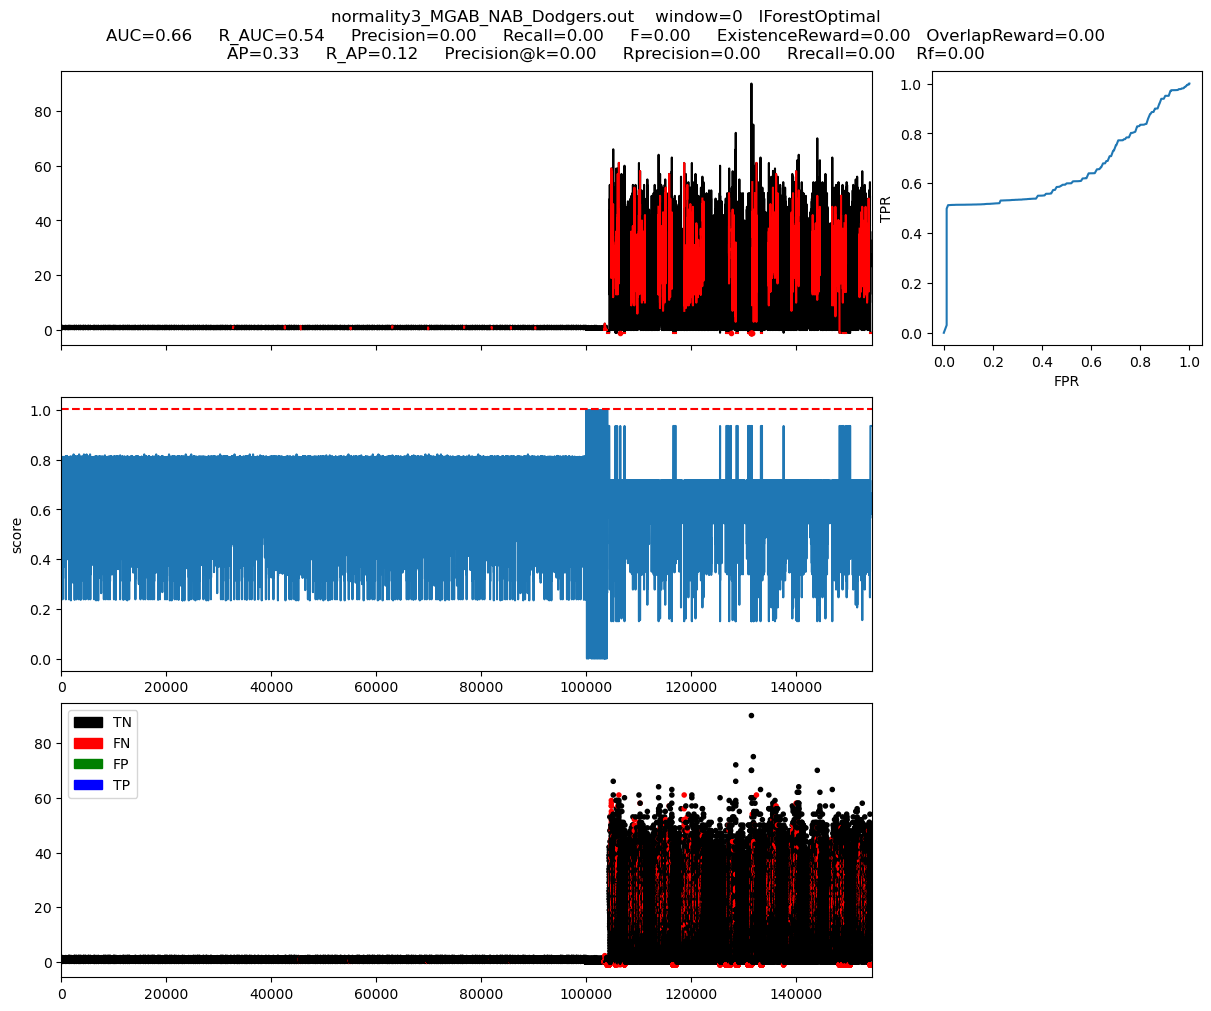



generated_data\normality3_NAB_Dodgers_MGAB.out


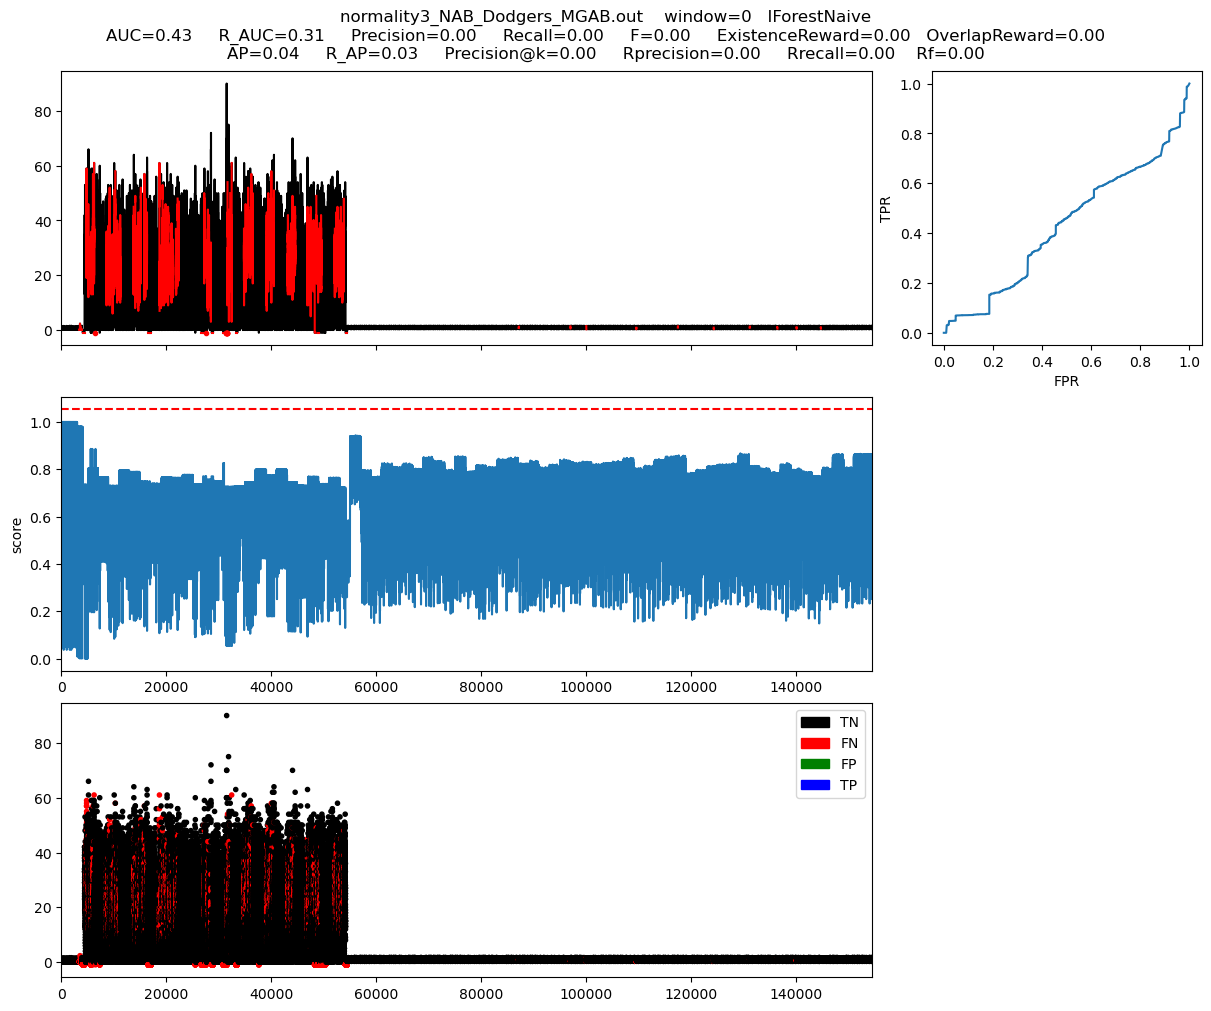

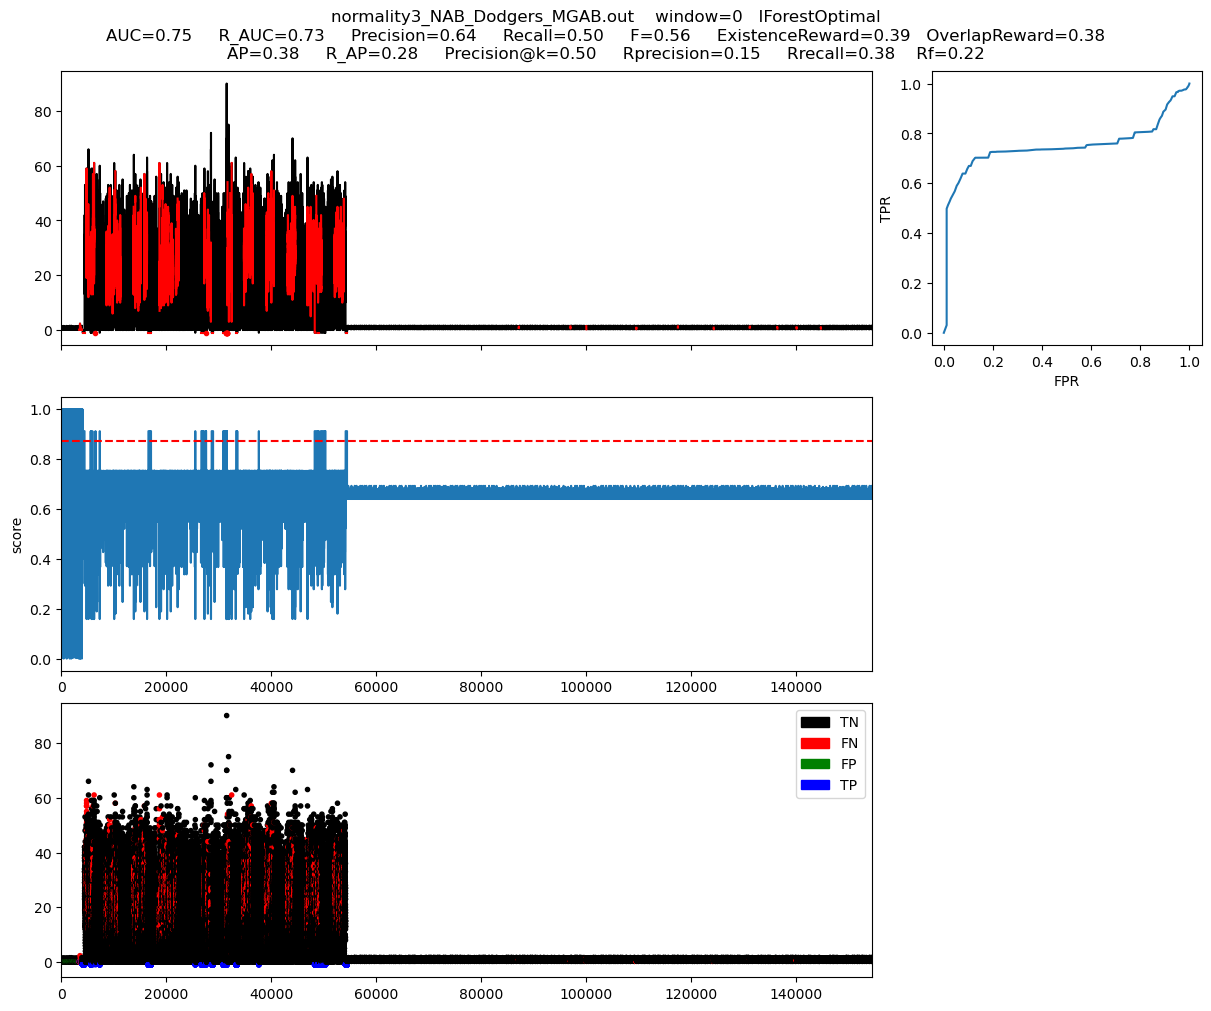



generated_data\normality3_NAB_MGAB_Dodgers.out


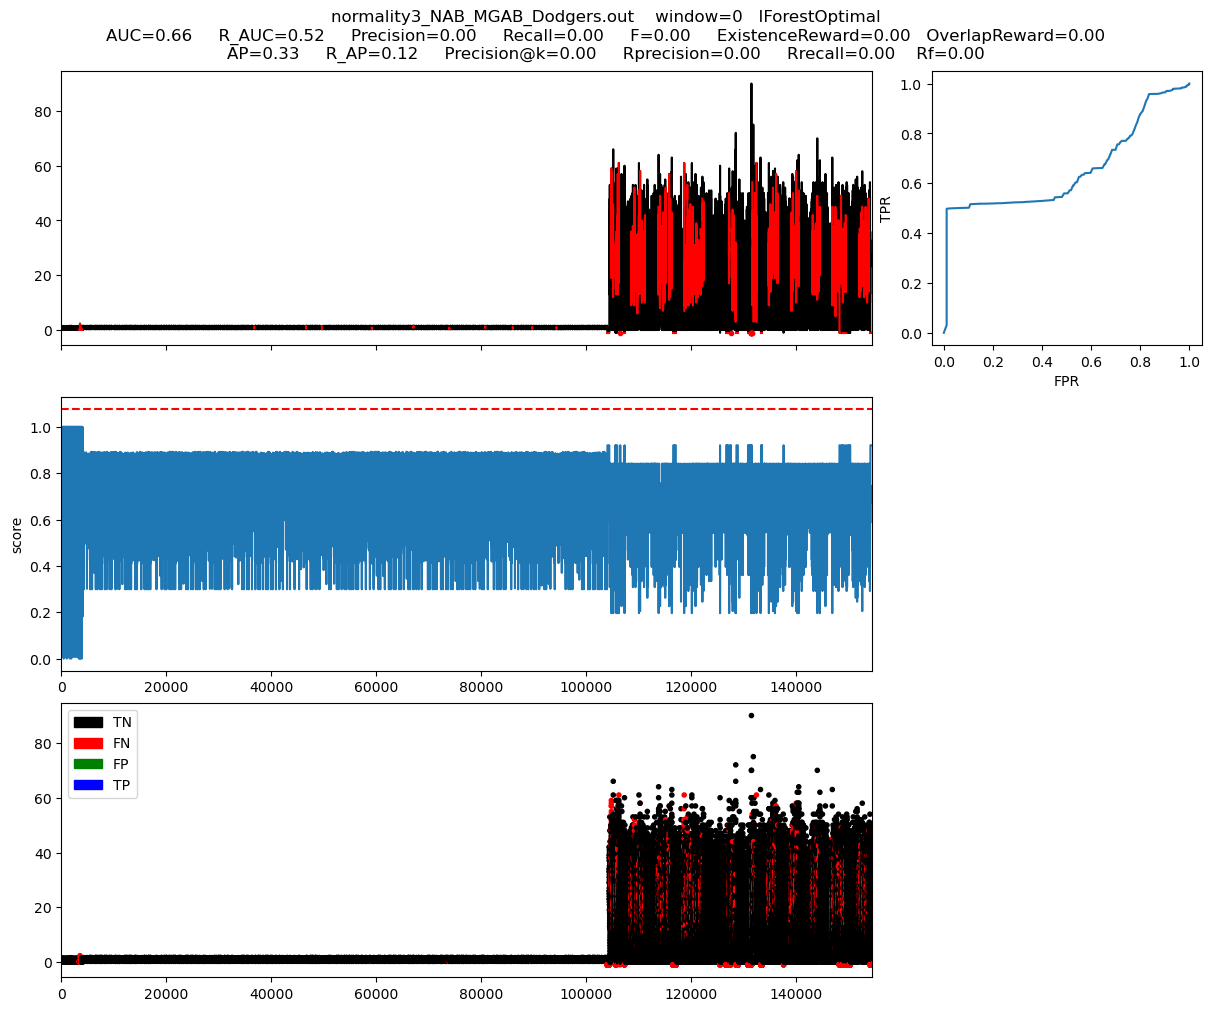

In [1]:
from pathlib import Path
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import iforest_naive
import iforest_optimal
from utils.slidingWindows import plotFig
from sklearn import metrics

directory = 'generated_data/'

compare_df = pd.DataFrame(columns=['file_name', 'optimal', 'AUC'])

def update_df(auc, file_name, optimal):
    new_row = {'AUC': auc,
               'file_name': file_name,
               'optimal': optimal}
    compare_df.loc[len(compare_df)] = new_row
    
def iforest_naiv():
    model_name = 'IForestNaive'
    clf = iforest_naive.IsolationForestNaiveStream()
    x = data
    clf.fit(x, init_length=1000, batch_size=2000)
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
    auc = metrics.roc_auc_score(label, score)
    update_df(auc, name, False)
    plotFig(data, label, score, 0, fileName=name, modelName=model_name)


def iforest_op():
    model_name = 'IForestOptimal'
    clf = iforest_optimal.IsolationForestStream(anomaly_threshold=0.6,
                                                window_size=1000,
                                                drift_threshold=0.5)
    x = data
    clf.fit(x, init_length=1000)
    score = clf.decision_scores_
    score = MinMaxScaler(feature_range=(0, 1)).fit_transform(score.reshape(-1, 1)).ravel()
    auc = metrics.roc_auc_score(label, score)
    update_df(auc, name, True)
    plotFig(data, label, score, 0, fileName=name, modelName=model_name)


for filepath in sorted(Path(directory).iterdir()):
    if filepath.is_file():
        print(filepath)
        name = str(filepath).split('\\')[-1]
    
        df = pd.read_csv(filepath, header=None).dropna().to_numpy()

        max_length = len(df)
        
        data = df[:max_length, 0].astype(float)
        label = df[:max_length, 1].astype(int)
        
        iforest_naiv()
        iforest_op()
        print()
        print()
                

Below we are going to create a dataframe that has only the auc value for variant 1 and 2 (non-optimal and optimal) for each file.

In [2]:
# create a pivot table for 'optimal' values (true, false)
optimal_pivot = compare_df.pivot_table(index='file_name', columns='optimal', values='AUC', aggfunc='first')

# reset the index to make 'file_name' a column again
optimal_pivot.reset_index(inplace=True)

# melt the pivoted DataFrame to long format
melted_optimal = optimal_pivot.melt(id_vars='file_name', var_name='optimal', value_name='AUC')

# pivot the melted DataFrame to get 'optimal' and 'AUC' as rows
pivoted_df = melted_optimal.pivot(index='optimal', columns='file_name', values='AUC')


# function to highlight the maximum value in bold
def highlight_max(s):
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

# apply style function to the data frame
styled_df = pivoted_df.style.apply(highlight_max, axis=0)

# display the styled DataFrame
display(styled_df)

We can see that for all files our optimal implementation outperforms the naive approach.
The only exception are files 

In [9]:
def assign_normality(file_name):
    if file_name.startswith('normality1'):
        return 'normality1'
    elif file_name.startswith('normality2'):
        return 'normality2'
    elif file_name.startswith('normality3'):
        return 'normality3'


compare_df['normality'] = compare_df['file_name'].apply(assign_normality)

# group by normality and optimal and calculate the mean value of AUC
result = compare_df.groupby(['normality', 'optimal'])['AUC'].mean().reset_index()

pivot_table = result.pivot(index='normality', columns='optimal', values='AUC').reset_index()

pivot_table.columns = ['normality', 'AUC_Naive', 'AUC_Optimal']

# function to highlight the maximum value in bold
def highlight_max(row):
    style = ['' for _ in row]
    if pd.notna(row['AUC_Naive']) and pd.notna(row['AUC_Optimal']):
        if row['AUC_Naive'] > row['AUC_Optimal']:
            style[1] = 'font-weight: bold'
        elif row['AUC_Optimal'] > row['AUC_Naive']:
            style[2] = 'font-weight: bold'
        else:  # If they are equal, bold both
            style[1] = style[2] = 'font-weight: bold'
    elif pd.notna(row['AUC_Naive']):
        style[1] = 'font-weight: bold'
    elif pd.notna(row['AUC_Optimal']):
        style[2] = 'font-weight: bold'
    return style

# apply style function to the data frame
styled_df = pivot_table.style.apply(highlight_max, axis=1)

display(styled_df)